In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
import random
import copy
from tqdm import tqdm

# import sklearn
from sklearn.linear_model import LinearRegression, LassoLarsIC, LassoCV, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.metrics import confusion_matrix  #, f1_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from scipy.stats import multivariate_normal, bernoulli

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.distributions import Bernoulli
# from torchsummary import summary

import multiprocessing as mp


import os
import sys

# CNAE-9

In [47]:
cnae = pd.read_csv('./real_data/CNAE-9.data', sep=',', header=None)

X = cnae.loc[:, 1:].to_numpy()
Y = cnae.loc[:, 0].to_numpy()

X.shape, Y.shape

((1080, 856), (1080,))

In [11]:
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
regr = SVC(gamma='auto')
regr.fit(x_train, y_train)
print(regr.score(x_test, y_test))
regr = RandomForestClassifier(max_depth=5)
regr.fit(x_train, y_train)
print(regr.score(x_test, y_test))
rf_sfm = SelectFromModel(regr, prefit=True)
rf = np.where(rf_sfm.get_support())[0]
# regr = RandomForestClassifier(max_depth=5)
regr = SVC(gamma='auto')
regr.fit(x_train[:, rf], y_train)
print(regr.score(x_test[:, rf], y_test))

0.8240740740740741
0.8858024691358025
0.9135802469135802


In [15]:
def compute_reward(X_train, Y_train, X_test, Y_test, actions, hiddens=(128, ), num_iter=500, lr=1e-3, batch_size='auto', dictionary=dict()):
    reward_list = []
    for i, action in enumerate(actions):
        
        idx = np.where(action == 1)[0]
        
        if tuple(idx) in dictionary:
            reward_list.append(dictionary[tuple(idx)])
        else:
            X_select = X_train[:, idx]        
#             reg_clf = MLPRegressor(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
#                                      learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
#             reg_clf = LinearRegression(fit_intercept=False)
            # reg_clf = Ridge(alpha=0.1)
            # reg_clf = RandomForestRegressor(n_estimators=50, max_depth=5)
            # reg_clf = ExtraTreesRegressor(n_estimators=50, max_depth=5)
            reg_clf = MLPClassifier(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
                                     learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
            # reg_clf = RandomForestClassifier(n_estimators=50, max_depth=5)
#             reg_clf = ExtraTreesClassifier(n_estimators=50)
            reg_clf.fit(X_select, Y_train)
            X_select = X_test[:, idx] 
            score = reg_clf.score(X_select, Y_test)
            # mse = np.mean((Y_test - regressor.predict(X_select))**2)
            dictionary[tuple(idx)] = score
            reward_list.append(score)
        
    return np.array(reward_list)

In [16]:
def metrics_cv(idx, X, Y, cv=5):
#     clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf = SVC(gamma='auto')
#     clf = RandomForestRegressor()
    return cross_val_score(clf, X[:, idx], Y, cv=cv)



m, n = X.shape

In [48]:
# ============================= one run ==========================================
start = time.time()

# training steps
batch_size = 64
seed = 4
np.random.seed(seed)
torch.manual_seed(seed)

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.01, random_state=seed)

# scaler_x = StandardScaler()
# x_train = scaler_x.fit_transform(x_train)
# x_test = scaler_x.transform(x_test)

x_tt, x_val, y_tt, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=seed)  
r_list = []
dictionary = dict()
theta = np.zeros(n) + 0.5
p_list = []
w_norm = []


for step in range(200):
    print('step: ', step)

    p_list.append(theta)
#     idx_select = np.where(theta > 0.9)[0]
    
    actions = np.zeros((batch_size, n))
    p = torch.from_numpy(theta)
    for i in range(batch_size):
        action = torch.bernoulli(p)
        if action.sum == 0:
            idx = np.random.randint(0, n, int(n/3))
            action[idx] = 1
        actions[i, :] = action.numpy()
#         idx = np.random.choice(np.where(action == 1)[0], int(n/4), replace=False)
#         tmp = np.zeros(n)
#         tmp[idx] = 1
#         tmp[idx_select] = 1
#         actions[i, :] = tmp


    rewards = compute_reward(x_tt, y_tt, x_val, y_val, actions, hiddens=(128, ), num_iter=10, lr=1e-2, batch_size='auto', dictionary=dictionary)
    r_list.append(rewards.mean())
    print(f'average reward: {rewards.mean()}')
#     rewards = torch.tensor(rewards, dtype=torch.float32)


    # sampled natural policy gradient
    log_pi_grad = actions / theta - (1 - actions)/(1 - theta)


    reg = Ridge(alpha=0.05)
    reg.fit(log_pi_grad, rewards)
    w = reg.coef_

    w_norm.append(np.linalg.norm(w))

    theta = theta + 1 * w    
    theta = np.clip(theta, 0.02, 0.98)


#     if step > 6:
#         if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
#             & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
#             print(f'converge at step {step}')
#             break

    if np.linalg.norm(theta - p_list[-1]) < 1e-3:
        print(f'converge at step {step}')
        break

end = time.time()
print(f'rd: {seed} take {datetime.timedelta(seconds = end - start)}')

step:  0


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.780373831775701
step:  1


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7827589563862928
step:  2


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7829049844236761
step:  3


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7863609813084111
step:  4


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7718068535825544
step:  5


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7913746105919004
step:  6


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7743380062305296
step:  7


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7817367601246106
step:  8


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.78952492211838
step:  9


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7767718068535825
step:  10


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7889894859813084
step:  11


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7826616043613708
step:  12


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7779400311526479
step:  13


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7884053738317758
step:  14


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7801304517133956
step:  15


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7867990654205608
step:  16


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.779595015576324
step:  17


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7773072429906541
step:  18


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7838298286604362
step:  19


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7841705607476634
step:  20


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7818827881619937
step:  21


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7894275700934579
step:  22


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7861662772585669
step:  23


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.784559968847352
step:  24


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7830510124610592
step:  25


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7794003115264797
step:  26


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7907418224299065
step:  27


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7737538940809969
step:  28


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7837324766355139
step:  29


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7932729750778816
step:  30


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.787042445482866
step:  31


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7822235202492211
step:  32


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7836838006230529
step:  33


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7855334890965733
step:  34


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7749707943925233
step:  35


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7772585669781931
step:  36


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7823208722741433
step:  37


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7856795171339563
step:  38


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7808605919003115
step:  39


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7880159657320871
step:  40


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7836351246105919
step:  41


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7785241433021806
step:  42


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7823208722741433
step:  43


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7810552959501558
step:  44


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7856308411214953
step:  45


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7822235202492211
step:  46


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7935163551401869
step:  47


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7800817757009346
step:  48


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7776966510903427
step:  49


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.780422507788162
step:  50


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7876265576323986
step:  51


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7867503894080997
step:  52


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7840245327102804
step:  53


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.786993769470405
step:  54


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7828563084112149
step:  55


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7966316199376946
step:  56


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.791131230529595
step:  57


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7844626168224299
step:  58


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7778426791277259
step:  59


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7848033489096573
step:  60


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7852414330218068
step:  61


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7881619937694704
step:  62


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7848033489096573
step:  63


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7829536604361371
step:  64


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7939057632398754
step:  65


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7842679127725856
step:  66


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7884540498442367
step:  67


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7879672897196262
step:  68


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7888921339563864
step:  69


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7802764797507789
step:  70


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7987246884735202
step:  71


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7939057632398754
step:  72


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.787918613707165
step:  73


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7851927570093458
step:  74


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7918613707165109
step:  75


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7876265576323989
step:  76


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7883080218068537
step:  77


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7895735981308412
step:  78


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7913259345794392
step:  79


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7819801401869159
step:  80


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7842192367601246
step:  81


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7868477414330217
step:  82


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7868964174454828
step:  83


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7816394080996885
step:  84


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7811526479750779
step:  85


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7833430685358255
step:  86


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7843652647975077
step:  87


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7830996884735202
step:  88


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7996495327102803
step:  89


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.786945093457944
step:  90


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7862636292834891
step:  91


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7882106697819314
step:  92


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7866043613707165
step:  93


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7937110591900312
step:  94


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7862149532710281
step:  95


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7826616043613708
step:  96


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7830996884735203
step:  97


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7917153426791277
step:  98


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.791861370716511
step:  99


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7809092679127726
step:  100


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7935163551401869
step:  101


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7868477414330218
step:  102


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.791131230529595
step:  103


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7945872274143302
step:  104


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7875778816199377
step:  105


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.790255062305296
step:  106


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7868964174454829
step:  107


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7908391744548287
step:  108


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7877725856697819
step:  109


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7932729750778815
step:  110


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7880159657320872
step:  111


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.777940031152648
step:  112


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7955120716510904
step:  113


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7892815420560748
step:  114


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7905471183800623
step:  115


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7830510124610591
step:  116


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7844626168224299
step:  117


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7864583333333334
step:  118


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7819314641744548
step:  119


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7848520249221183
step:  120


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7924941588785047
step:  121


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7940031152647975
step:  122


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7885514018691588
step:  123


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7865556853582554
step:  124


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7976051401869159
step:  125


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7845599688473519
step:  126


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7962422118380061
step:  127


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.783683800623053
step:  128


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.789573598130841
step:  129


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7932242990654206
step:  130


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7980432242990654
step:  131


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7941491433021807
step:  132


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7887947819314642
step:  133


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.8008177570093458
step:  134


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7906931464174455
step:  135


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.786117601246106
step:  136


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7896222741433022
step:  137


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.8028134735202492
step:  138


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7944898753894081
step:  139


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.784511292834891
step:  140


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7945385514018691
step:  141


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7860202492211836
step:  142


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.8023267133956387
step:  143


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.8047118380062306
step:  144


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7969236760124611
step:  145


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.795317367601246
step:  146


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.792786214953271
step:  147


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.794392523364486
step:  148


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7979458722741433
step:  149


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7922507788161993
step:  150


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7881619937694704
step:  151


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7881619937694704
step:  152


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7943438473520249
step:  153


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7958041277258567
step:  154


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7971670560747663
step:  155


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.796875
step:  156


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7979945482866044
step:  157


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.8039816978193146
step:  158


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.792786214953271
step:  159


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.788648753894081
step:  160


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7934190031152647
step:  161


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7891355140186915
step:  162


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7944411993769471
step:  163


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7894275700934579
step:  164


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7983839563862928
step:  165


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7934190031152648
step:  166


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7963882398753894
step:  167


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7975077881619937
step:  168


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7917640186915886
step:  169


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7899143302180685
step:  170


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7804711838006231
step:  171


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7970697040498442
step:  172


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.8041277258566978
step:  173


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7941491433021806
step:  174


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7926401869158878
step:  175


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7897196261682242
step:  176


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.8038843457943925
step:  177


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.8027647975077882
step:  178


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7966316199376946
step:  179


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7957554517133956
step:  180


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.8003796728971962
step:  181


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7924454828660437
step:  182


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7996982087227414
step:  183


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7922507788161994
step:  184


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7999415887850467
step:  185


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.8019859813084113
step:  186


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.8090440031152648
step:  187


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7932729750778815
step:  188


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.8033489096573209
step:  189


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7931756230529595
step:  190


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7991627725856698
step:  191


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.800184968847352
step:  192


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7868477414330217
step:  193


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.8002823208722741
step:  194


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.8016939252336449
step:  195


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7973617601246106
step:  196


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7915206386292835
step:  197


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7912285825545171
step:  198


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7908391744548287
step:  199


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWar

average reward: 0.7885027258566978
rd: 4 take 0:30:44.037139


D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
D:\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[0.5  0.5  0.5  0.51 0.49 0.5  0.51 0.5  0.5  0.5  0.51 0.5  0.5  0.5
 0.49 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.49 0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5
 0.49 0.5  0.49 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.49 0.51 0.5
 0.5  0.5  0.51 0.51 0.5  0.51 0.51 0.5  0.5  0.5  0.49 0.5  0.5  0.5
 0.51 0.5  0.52 0.51 0.51 0.51 0.51 0.51 0.51 0.5  0.5  0.5  0.5  0.49
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5
 0.5  0.51 0.49 0.5  0.5  0.5  0.57 0.5  0.5  0.5  0.51 0.49 0.51 0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.51 0.5  0.5  0.51 0.5  0.51 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.54 0.5  0.49 0.49 0.5  0.51
 0.5  0.5  0.5  0.

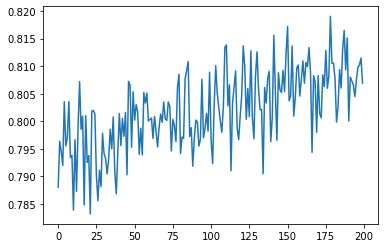

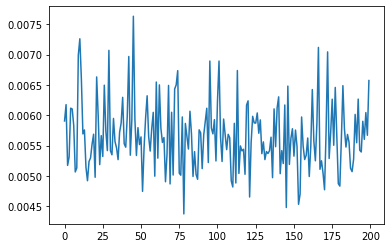

In [18]:
plt.plot(r_list)
print(np.round(theta, 2))
print(np.where(theta > 0.90)[0]+1)
print(np.argsort(theta)[::-1]+1)
plt.figure()
plt.plot(w_norm)

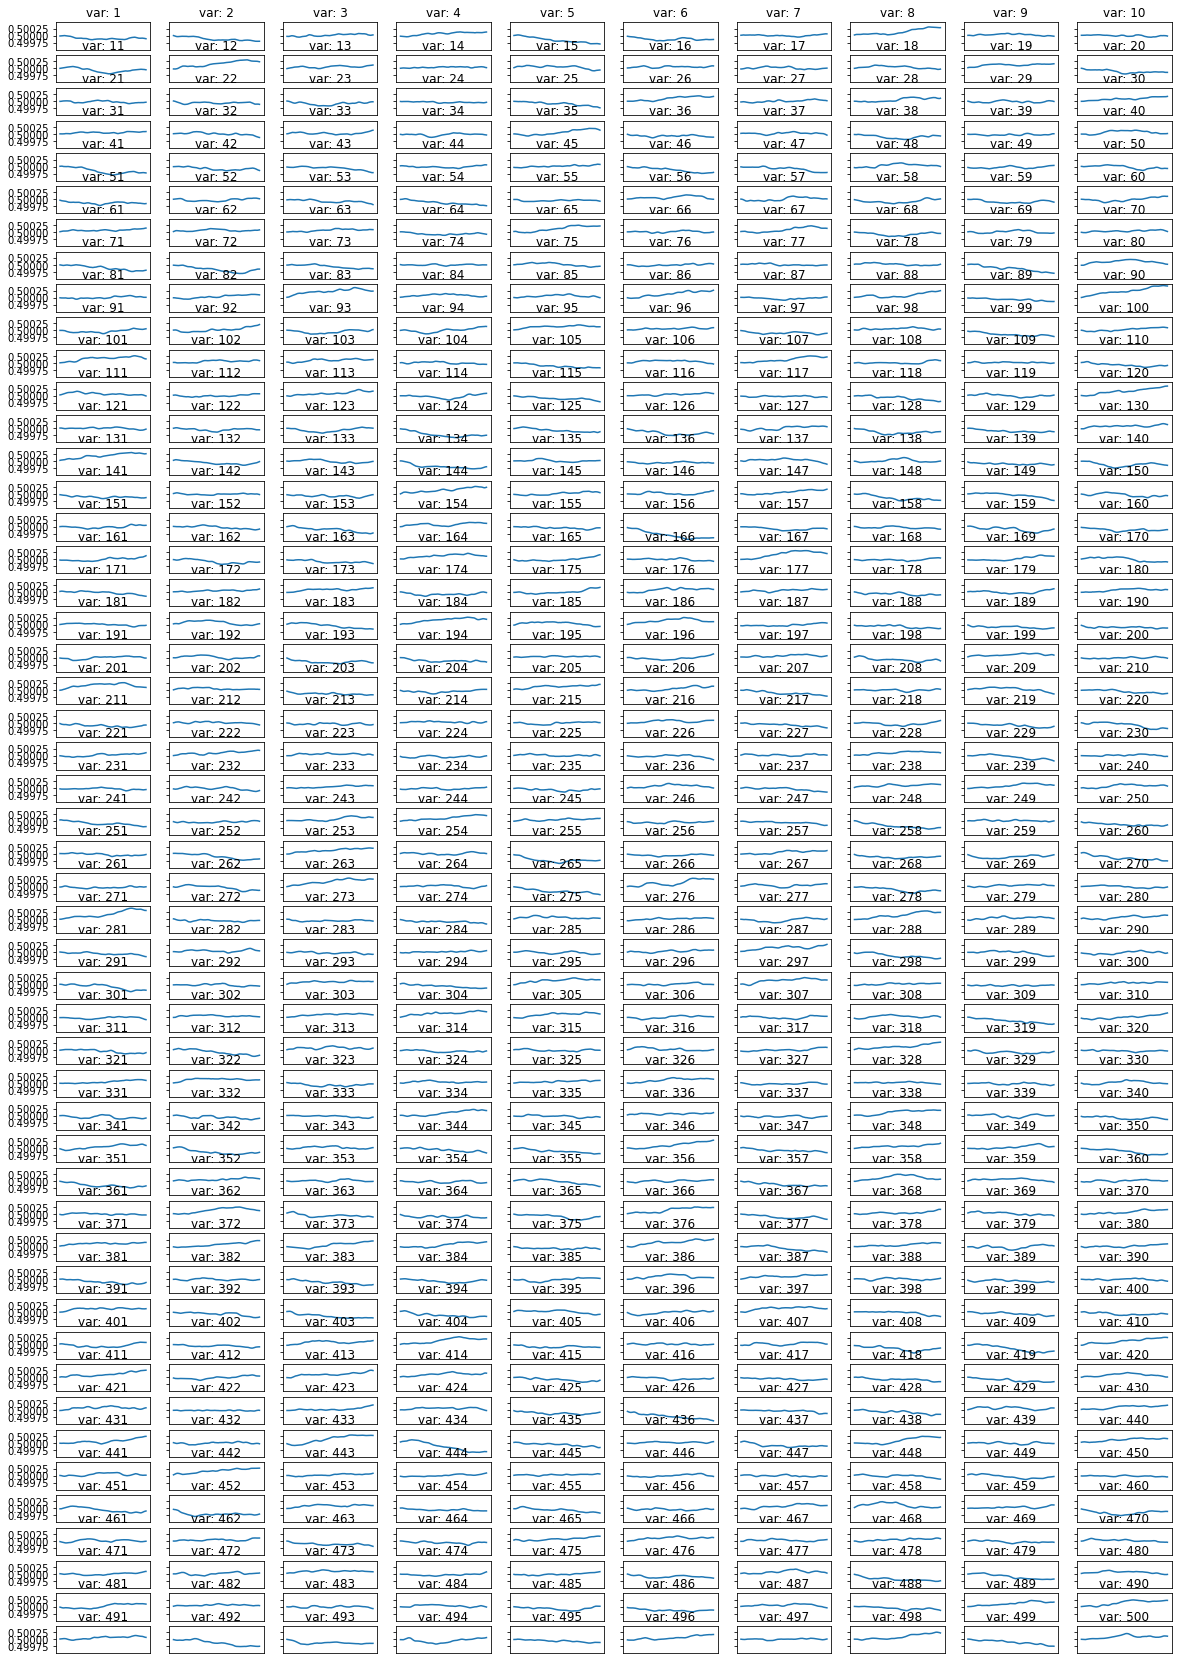

In [86]:
probs = np.array(p_list)
fig, axes = plt.subplots(int(n/10+0.9), 10, figsize=(20, 30), sharex=False, sharey=True)
# plt.subplots_adjust(
# top=0.965,
# bottom=0.09,
# left=0.03,
# right=0.83,
# hspace=0.52,
# wspace=0.18)
# fig.tight_layout()
num = 0
for i in range(int(n/10+0.9)):
    for j in range(10):
        axes[i, j].plot(pd.Series(np.array(probs)[:, num]).rolling(10).mean())
        axes[i, j].set_title(f'var: {num+1}')
        if i != int(n/8)-1: axes[i, j].set_xticks([]) 
        num += 1

In [373]:
# tmp = sorted(dictionary.items(), key=lambda x: x[1])
# s = set(range(n))
# for item in tmp[:5]:
#     s = s & set(item[0])
# dic = np.array(list(s))
# print('dictionary: ', dic)


npg = np.where(theta > 0.5)[0]
print('npg: ', npg)


regr = LogisticRegression(penalty='l2', fit_intercept=False, max_iter=1e6)
regr.fit(x_train, y_train)
lr_sfm = SelectFromModel(regr, prefit=True)
lr2 = np.where(lr_sfm.get_support())[0]
print('logistic_l2: ', lr2)

regr = RandomForestClassifier(max_depth=5, random_state=0)
regr.fit(x_train, y_train)
rf_sfm = SelectFromModel(regr, prefit=True)
rf = np.where(rf_sfm.get_support())[0]
print('random_forest: ', rf)

npg:  [  1   3   6   8   9  11  12  16  18  19  22  23  25  26  27  28  29  32
  35  36  37  39  41  45  54  55  57  58  59  60  61  62  67  69  72  73
  74  75  76  77  78  85  88  90  92  95  96  97  99 101 102 104 105 106
 107 108 110 111 112 113 115 116 118 120 121 123 128 129 132 133 134 135
 136 139 140 142 143 144 147 148 149 150 151 155 156 157 159 160 161 162
 164 165 167 168 169 171 173 176 177 178 180 181 182 183 185 186 187 189
 190 191 195 198 199 200 201 202 203 205 206 207 208 209 210 213 214 215
 218 219 222 223 224 225 227 228 229 231 233 234 235 236 237 238 239 241
 242 246 247 249 250 251 252 253 254 255 257 258 261 263 268 269 270 271
 272 273 274 277 279 280 281 282 285 287 289 293 294 295 296 299 300 305
 306 307 308 309 310 312 313 314 315 316 317 318 320 321 323 324 325 326
 327 330 332 333 334 336 337 340 342 343 344 345 347 348 349 350 352 357
 358 360 364 369 371 372 375 376 377 378 379 380 381 382 386 387 391 392
 394 396 398 399 402 403 404 407 410 411 412 

In [374]:
dat = np.zeros((2, 4))
dat[0, 3] = 57; dat[1, 3] = metrics_cv(range(n), X, Y).mean()
dat[0, 0] = len(npg); dat[0, 1] = len(lr2); dat[0, 2] = len(rf)
dat[1, 0] = metrics_cv(npg, X, Y).mean()
dat[1, 1] = metrics_cv(lr2, X, Y).mean()
dat[1, 2] = metrics_cv(rf, X, Y).mean()  

print(dat)

[[490.         245.          76.          57.        ]
 [  0.83148148   0.9212963    0.87962963   0.80925926]]


## performances of different numer of selected features

In [49]:
num_selected = 300
dats = np.zeros((num_selected, 4))

for num in range(1, num_selected):

    npg = np.argsort(theta)[::-1][:num]
    print('npg: ', np.sort(npg))

    regr = LogisticRegression(penalty='l2', fit_intercept=False, max_iter=1e6)
    regr.fit(x_train, y_train)
    lr2 = np.argsort(regr.coef_[0])[::-1][:num]
    print('logistic_l2: ',  np.sort(lr2))

    regr = RandomForestClassifier(max_depth=5, random_state=num)
    regr.fit(x_train, y_train)
    rf = np.argsort(regr.feature_importances_)[::-1][:num]
    print('random_forest: ',  np.sort(rf))
    
    dats[num, 0] = metrics_cv(npg, X, Y).mean() 
    dats[num, 1] = metrics_cv(lr2, X, Y).mean()
    dats[num, 2] = metrics_cv(rf, X, Y).mean()
    
dats[:, 3] = metrics_cv(range(n), X, Y).mean()
    
dats

npg:  [545]
logistic_l2:  [206]
random_forest:  [545]
npg:  [545 606]
logistic_l2:  [206 704]
random_forest:  [190 545]
npg:  [545 606 618]
logistic_l2:  [206 332 704]
random_forest:  [206 386 545]
npg:  [518 545 606 618]
logistic_l2:  [206 332 333 704]
random_forest:  [206 386 545 850]
npg:  [518 545 606 618 831]
logistic_l2:  [206 332 333 381 704]
random_forest:  [190 206 386 545 704]
npg:  [210 518 545 606 618 831]
logistic_l2:  [206 332 333 344 381 704]
random_forest:  [257 344 386 518 545 704]
npg:  [206 210 518 545 606 618 831]
logistic_l2:  [206 332 333 344 381 446 704]
random_forest:  [206 257 386 420 545 630 850]
npg:  [206 210 271 518 545 606 618 831]
logistic_l2:  [206 332 333 344 381 446 704 829]
random_forest:  [257 344 386 420 518 545 630 704]
npg:  [201 206 210 271 518 545 606 618 831]
logistic_l2:  [206 332 333 344 381 446 510 704 829]
random_forest:  [190 201 206 210 257 386 545 630 704]
npg:  [104 201 206 210 271 518 545 606 618 831]
logistic_l2:  [206 229 332 333 344

random_forest:  [150 190 201 206 210 257 271 337 344 378 386 402 420 478 486 501 510 512
 517 518 545 552 560 594 606 607 630 672 704 725 730 813 831 850]
npg:  [ 72  74 104 190 201 206 210 271 300 337 358 378 386 402 420 486 498 501
 517 518 545 560 594 606 607 609 614 618 630 672 683 704 725 813 831]
logistic_l2:  [ 98 106 126 133 134 186 196 206 207 229 275 296 306 331 332 333 344 381
 427 446 493 494 510 530 536 571 602 633 704 713 751 767 776 805 829]
random_forest:  [150 190 201 206 210 257 271 337 344 378 386 402 420 424 478 486 501 510
 512 517 518 545 560 594 606 607 630 686 704 725 730 813 822 831 850]
npg:  [ 72  74 104 190 201 206 210 271 300 337 358 378 386 402 420 486 498 501
 517 518 545 560 589 594 606 607 609 614 618 630 672 683 704 725 813 831]
logistic_l2:  [ 98 106 126 133 134 186 196 206 207 229 275 296 306 331 332 333 344 381
 413 427 446 493 494 510 530 536 571 602 633 704 713 751 767 776 805 829]
random_forest:  [150 190 201 206 210 215 257 271 337 344 378 386 4

random_forest:  [ 76 104 126 150 151 169 190 201 206 210 215 257 271 337 344 358 378 386
 402 420 424 446 455 478 486 498 501 510 512 517 518 522 545 560 594 606
 607 614 618 630 672 686 704 725 730 813 831 836 850]
npg:  [ 10  59  62  72  74  76  86 104 110 149 190 201 206 210 271 300 337 344
 358 378 386 402 420 446 468 482 486 498 501 517 518 545 552 560 589 594
 606 607 609 614 618 630 672 683 704 725 730 813 822 831]
logistic_l2:  [ 68  98 100 106 112 126 133 134 186 196 206 207 226 229 275 287 296 306
 331 332 333 344 381 413 426 427 446 493 494 510 519 530 536 547 571 582
 602 633 643 675 704 713 751 754 766 767 776 805 808 829]
random_forest:  [ 72  75 104 106 126 132 150 151 190 201 206 210 215 257 271 290 337 344
 378 386 402 420 424 446 475 486 498 501 510 512 517 518 545 552 560 594
 606 607 618 630 649 672 686 704 725 730 813 822 831 850]
npg:  [ 10  59  62  72  74  76  86 104 110 149 190 201 206 210 271 300 333 337
 344 358 378 386 402 420 446 468 482 486 498 501 517 518 

random_forest:  [  6  10  29  62  72  75  76 104 106 122 126 132 150 151 190 201 206 210
 215 257 271 332 337 344 378 386 402 420 424 446 455 475 478 486 498 501
 510 512 517 518 522 545 552 560 594 606 607 614 618 630 649 672 686 690
 704 725 730 813 822 831 850]
npg:  [ 10  59  62  72  74  76  86  95 104 110 149 182 190 201 206 210 257 271
 300 333 337 344 358 378 386 392 402 410 420 446 462 468 482 486 498 501
 517 518 545 546 552 560 575 580 589 594 606 607 609 612 614 618 630 649
 672 683 704 725 730 813 822 831]
logistic_l2:  [  8  56  68  98 100 101 106 112 126 133 134 184 186 196 206 207 226 229
 230 255 275 287 296 306 331 332 333 344 381 393 413 426 427 446 493 494
 510 519 530 536 547 571 582 602 633 643 675 704 713 751 752 753 754 762
 766 767 776 803 805 808 815 829]
random_forest:  [ 11  62  72  75  76  95 104 122 126 128 150 151 190 201 206 210 215 257
 271 290 332 337 344 378 386 402 410 420 424 446 455 475 478 486 498 501
 510 512 517 518 545 552 560 594 606 607 614 61

random_forest:  [  6  10  29  39  62  72  75  76  90 104 106 126 133 150 169 190 201 206
 210 215 257 271 275 279 290 337 340 344 346 358 378 386 402 420 424 446
 455 475 478 486 493 498 501 512 517 518 522 545 552 560 570 594 606 607
 614 618 630 649 672 686 704 713 725 730 813 822 831 836 838 850 854]
npg:  [ 10  59  62  72  74  76  86  91  95 104 110 126 132 149 151 182 190 201
 206 210 257 271 300 332 333 336 337 344 358 378 386 392 402 410 420 446
 462 468 475 482 486 497 498 501 517 518 545 546 552 560 575 580 589 594
 606 607 609 612 614 618 630 649 661 672 683 686 704 725 730 813 822 831]
logistic_l2:  [  8  56  68  98 100 101 106 112 126 127 133 134 184 186 196 206 207 225
 226 229 230 255 272 275 287 296 306 331 332 333 344 381 393 413 426 427
 436 446 493 494 510 514 519 520 530 536 544 547 571 582 602 633 643 659
 675 704 713 720 751 752 753 754 762 766 767 776 803 805 808 815 828 829]
random_forest:  [  6  10  29  39  54  62  72  75  76  90 104 122 126 132 150 151 169 190


random_forest:  [  6  10  11  29  39  62  72  74  75  76 104 106 122 126 128 150 151 190
 201 206 210 215 229 233 257 271 279 332 336 337 344 346 349 358 362 365
 378 386 402 410 420 424 455 462 475 478 482 486 489 498 501 510 512 517
 518 522 545 552 560 594 606 607 614 618 630 641 649 672 686 704 713 725
 730 813 822 831 836 838 850 854]
npg:  [ 10  59  61  62  72  74  75  76  86  91  95 104 110 126 132 149 151 161
 182 190 201 206 210 257 271 300 332 333 336 337 344 349 358 378 386 392
 402 410 420 446 462 468 475 482 486 497 498 501 512 513 517 518 532 545
 546 552 560 575 580 589 594 606 607 609 612 614 618 630 649 661 672 683
 686 704 725 730 813 822 831 850 854]
logistic_l2:  [  8  15  31  56  67  68  69  98 100 101 106 112 126 127 133 134 184 186
 192 196 206 207 225 226 229 230 243 255 272 275 287 296 306 331 332 333
 342 344 381 393 413 426 427 436 446 493 494 510 514 519 520 530 536 544
 547 571 582 602 633 643 659 675 704 713 720 751 752 753 754 762 766 767
 772 776 782 803

random_forest:  [  6  10  11  29  39  54  62  72  75  76 101 104 106 122 126 128 132 133
 149 150 151 169 190 200 201 206 209 210 215 229 233 257 271 279 281 290
 332 337 344 346 378 382 386 402 420 424 446 455 467 475 478 486 493 498
 501 510 512 517 518 522 545 552 560 575 594 606 607 609 614 618 630 649
 655 672 686 690 704 725 730 745 813 814 822 829 831 836 850 854]
npg:  [ 10  53  59  61  62  72  74  75  76  86  91  95 104 110 126 132 149 151
 161 182 190 201 206 210 245 257 271 279 300 332 333 336 337 340 344 349
 358 370 374 378 386 392 402 410 420 446 461 462 468 475 482 486 497 498
 501 512 513 517 518 532 545 546 552 560 575 580 589 594 606 607 609 612
 614 618 630 649 661 672 683 686 704 725 730 791 813 822 831 850 854]
logistic_l2:  [  8  15  31  56  67  68  69  80  98 100 101 106 112 126 127 133 134 184
 186 192 196 206 207 225 226 229 230 243 255 267 272 275 287 296 302 306
 310 315 323 331 332 333 342 344 381 393 413 426 427 436 446 469 493 494
 510 514 519 520 530 536 

npg:  [ 10  53  59  61  62  72  74  75  76  86  91  95 104 110 126 132 149 151
 161 182 190 201 206 210 217 245 253 257 271 279 300 332 333 336 337 340
 344 348 349 358 370 374 378 386 392 402 410 420 422 423 446 461 462 468
 475 482 486 497 498 501 512 513 517 518 532 545 546 552 560 575 580 589
 594 606 607 609 612 614 618 630 649 661 672 683 686 704 725 730 737 791
 813 822 831 840 850 854]
logistic_l2:  [  8  15  31  56  67  68  69  80  98 100 101 106 112 126 127 133 134 184
 186 192 196 206 207 225 226 229 230 234 243 255 267 272 275 287 296 302
 306 310 315 316 320 323 331 332 333 342 344 381 393 413 426 427 436 446
 449 469 473 493 494 510 514 519 520 530 536 541 544 547 571 582 602 633
 643 659 675 704 713 720 738 751 752 753 754 762 766 767 772 776 782 786
 803 805 808 815 828 829]
random_forest:  [  6  10  29  39  54  62  72  75  76  90  91 104 106 122 125 126 128 132
 134 150 151 169 190 201 206 210 215 257 271 275 279 281 290 332 333 337
 339 344 346 351 358 361 365 378 386

random_forest:  [  6  10  11  29  39  52  62  70  72  74  75  76  90 104 106 122 126 128
 132 133 150 151 169 190 194 200 201 206 210 215 257 258 271 275 279 290
 311 327 332 336 337 339 340 344 346 347 358 378 386 402 403 420 424 446
 455 475 478 482 486 489 498 501 510 512 517 518 522 545 546 552 560 589
 594 606 607 614 618 630 641 647 649 660 661 672 683 686 690 704 725 730
 745 775 780 798 813 822 829 831 836 838 850 854]
npg:  [ 10  53  59  61  62  72  74  75  76  86  91  95 104 110 117 126 132 149
 151 161 182 190 201 206 210 215 217 245 253 257 271 279 300 332 333 336
 337 340 344 348 349 356 358 361 370 374 378 386 392 398 402 410 420 422
 423 424 446 461 462 468 475 482 486 497 498 501 512 513 517 518 532 545
 546 552 560 575 580 589 594 606 607 609 612 614 618 624 630 649 661 672
 683 686 704 725 730 737 791 813 822 831 840 850 854]
logistic_l2:  [  8  11  15  31  56  67  68  69  80  98 100 101 106 112 115 124 126 127
 133 134 172 184 186 192 194 196 206 207 208 225 226 229 

npg:  [ 10  19  53  59  61  62  72  74  75  76  86  91  95 104 110 117 126 132
 148 149 151 161 182 190 201 206 210 215 217 245 253 257 271 279 291 300
 332 333 336 337 340 344 348 349 356 358 361 370 374 378 386 392 398 402
 410 420 422 423 424 446 461 462 468 475 482 486 489 497 498 501 512 513
 517 518 532 545 546 552 560 575 580 589 594 606 607 609 612 614 618 624
 630 641 649 661 672 683 686 700 704 725 730 737 791 813 822 831 840 850
 854]
logistic_l2:  [  8  11  15  23  31  56  67  68  69  80  98 100 101 106 112 115 124 126
 127 133 134 172 184 186 192 194 196 206 207 208 225 226 229 230 234 243
 255 264 267 272 275 287 296 302 306 310 315 316 320 323 331 332 333 342
 344 381 393 411 413 426 427 436 446 449 464 469 473 493 494 510 514 519
 520 530 536 541 544 547 558 571 582 602 606 633 643 659 675 704 713 720
 738 751 752 753 754 758 762 766 767 772 776 782 786 803 805 808 815 828
 829]
random_forest:  [  6  10  11  29  39  62  70  72  74  75  76  91 104 118 122 125 126 132
 13

npg:  [ 10  19  53  59  61  62  72  74  75  76  86  91  95 104 110 117 126 132
 137 148 149 151 161 182 190 201 206 210 215 217 245 253 257 271 279 291
 300 332 333 336 337 340 344 348 349 356 358 361 362 370 374 378 386 392
 398 402 410 420 422 423 424 446 448 452 461 462 468 475 482 486 489 497
 498 501 512 513 517 518 532 545 546 552 560 572 575 580 589 594 606 607
 609 612 614 618 624 630 641 649 661 671 672 683 686 700 704 725 730 737
 791 813 822 831 840 850 854]
logistic_l2:  [  8  11  15  23  31  56  67  68  69  80  98 100 101 106 112 115 124 126
 127 133 134 172 183 184 186 192 194 196 206 207 208 225 226 228 229 230
 234 243 255 264 267 272 275 287 296 302 306 310 315 316 320 323 331 332
 333 342 344 381 393 411 413 426 427 436 446 449 464 469 473 493 494 510
 514 519 520 530 536 541 544 547 558 571 582 602 606 633 643 659 675 676
 704 713 720 733 738 751 752 753 754 758 762 766 767 772 776 781 782 786
 803 805 808 815 828 829 850]
random_forest:  [  6  10  11  39  54  62  70

random_forest:  [  6  10  29  32  39  54  62  72  75  76  91  95 104 106 122 125 126 132
 133 150 151 167 169 190 194 198 200 201 206 210 215 233 257 265 271 275
 279 281 290 298 308 314 318 336 337 340 344 346 349 358 378 386 394 402
 420 424 430 446 455 462 468 475 478 482 486 489 497 498 501 510 512 515
 517 518 522 532 543 545 546 552 560 580 584 594 606 607 608 612 614 618
 621 630 647 649 653 672 683 686 690 704 725 730 740 742 745 750 763 781
 791 798 813 814 822 828 829 831 836 838 850 854]
npg:  [ 10  19  53  59  61  62  72  74  75  76  86  91  95 104 110 117 125 126
 132 137 148 149 151 161 182 190 201 206 210 215 217 245 253 257 263 271
 275 279 291 300 332 333 336 337 340 344 346 348 349 356 358 361 362 370
 374 378 386 392 398 402 410 420 422 423 424 446 448 452 461 462 468 475
 482 486 489 497 498 501 512 513 517 518 532 545 546 552 560 572 575 580
 589 594 605 606 607 609 612 614 618 624 630 641 649 660 661 671 672 683
 686 700 704 725 730 737 791 813 822 831 840 850 854

random_forest:  [  6  10  11  19  29  39  52  54  62  72  74  75  76  84  90  91  95 104
 106 122 125 126 132 133 150 151 164 190 194 198 200 201 206 210 215 233
 257 271 279 290 314 320 327 332 333 336 337 340 344 346 347 357 358 362
 365 378 382 386 394 398 402 403 410 420 424 446 455 460 462 467 468 475
 476 478 482 486 498 501 510 512 517 518 522 536 545 546 552 560 580 584
 594 606 607 609 610 612 614 618 630 641 647 649 655 668 672 683 686 704
 713 725 730 745 775 786 796 798 813 814 822 829 831 836 837 838 850 854]
npg:  [ 10  14  19  53  59  61  62  72  74  75  76  86  91  95 104 110 117 125
 126 132 137 148 149 151 161 182 190 201 206 210 215 217 245 253 257 263
 271 275 279 291 296 300 332 333 336 337 340 344 346 348 349 356 358 361
 362 370 374 378 386 392 398 402 410 420 422 423 424 446 448 452 461 462
 468 475 480 482 486 489 497 498 501 506 512 513 517 518 532 545 546 552
 553 560 572 575 580 589 594 605 606 607 609 612 614 618 622 624 630 641
 649 660 661 671 672 683 686

npg:  [ 10  14  19  53  59  61  62  72  74  75  76  86  91  95 104 110 117 125
 126 132 137 148 149 151 161 179 182 190 201 206 210 215 217 245 253 257
 263 271 275 279 288 291 296 300 332 333 336 337 340 344 346 348 349 356
 358 361 362 370 374 378 386 387 392 398 402 410 420 422 423 424 446 448
 452 461 462 468 475 480 482 486 489 497 498 501 506 512 513 517 518 523
 532 545 546 552 553 560 564 572 575 580 589 594 605 606 607 609 612 614
 618 622 624 630 641 649 660 661 671 672 683 686 700 704 725 730 737 791
 813 822 831 840 850 854]
logistic_l2:  [  8  11  15  16  17  23  24  31  56  67  68  69  80  82  98 100 101 106
 112 115 122 124 126 127 133 134 154 172 183 184 186 192 194 196 206 207
 208 209 225 226 228 229 230 234 243 253 255 258 261 264 267 272 275 287
 296 302 306 310 315 316 320 323 331 332 333 340 342 344 367 381 393 411
 413 426 427 436 446 449 464 469 473 493 494 510 514 519 520 530 536 541
 544 547 558 571 582 586 590 592 602 606 624 633 643 659 675 676 704 713
 720 

npg:  [ 10  14  19  53  59  61  62  72  74  75  76  86  91  95 104 110 117 119
 125 126 132 137 148 149 151 161 163 179 182 190 201 206 209 210 215 217
 245 253 257 263 271 275 279 288 291 296 300 332 333 336 337 340 344 346
 348 349 356 358 361 362 370 374 378 386 387 392 398 402 410 420 422 423
 424 446 448 452 461 462 468 475 480 482 486 489 497 498 501 506 512 513
 517 518 523 532 545 546 552 553 560 564 572 575 580 589 594 605 606 607
 609 612 614 618 622 624 630 634 641 649 660 661 671 672 683 686 690 700
 704 725 730 737 791 813 822 831 840 850 854]
logistic_l2:  [  8  11  15  16  17  23  24  31  56  67  68  69  80  82  98 100 101 106
 112 115 122 124 126 127 133 134 136 154 172 183 184 186 192 194 196 206
 207 208 209 225 226 228 229 230 234 235 243 253 255 258 261 264 267 272
 275 287 296 302 305 306 310 315 316 320 323 331 332 333 340 342 344 367
 381 393 411 413 415 426 427 436 446 449 454 464 469 473 493 494 510 514
 519 520 530 536 541 544 547 558 571 582 586 590 592 602 6

npg:  [ 10  14  19  53  59  61  62  72  74  75  76  86  91  95 104 110 117 119
 125 126 132 137 148 149 151 160 161 163 179 182 190 201 206 209 210 215
 217 245 253 257 263 268 271 275 279 288 291 296 300 317 332 333 336 337
 340 344 346 348 349 356 358 361 362 370 374 378 386 387 392 398 402 410
 420 422 423 424 446 448 452 461 462 468 475 480 482 486 489 497 498 501
 506 512 513 517 518 523 532 541 545 546 552 553 560 564 572 575 580 589
 594 605 606 607 609 612 614 618 622 624 630 634 641 649 660 661 671 672
 683 686 690 700 704 725 730 737 740 791 813 822 831 840 850 854]
logistic_l2:  [  8  11  15  16  17  23  24  31  56  67  68  69  80  82  98 100 101 106
 107 112 115 122 124 126 127 133 134 136 154 169 172 183 184 186 192 194
 196 206 207 208 209 225 226 228 229 230 234 235 243 253 255 258 261 264
 267 272 275 287 296 302 305 306 310 315 316 320 323 331 332 333 340 342
 344 367 381 393 411 413 415 426 427 436 446 449 454 464 469 473 493 494
 510 514 519 520 530 536 541 544 547 5

random_forest:  [  6  10  11  18  29  39  52  62  68  72  74  75  76  90  95  97 104 106
 110 122 125 126 128 132 133 149 150 151 169 171 190 194 198 200 201 206
 209 210 215 229 233 240 246 257 258 271 275 279 281 286 290 300 311 314
 315 317 332 334 337 339 340 344 346 349 358 359 365 368 378 382 386 389
 402 416 420 422 424 427 432 446 455 462 467 475 478 486 489 493 497 498
 501 510 512 517 518 522 531 532 545 552 560 570 584 589 594 600 606 607
 609 610 614 618 624 630 647 649 653 655 660 672 683 686 687 690 704 713
 723 725 729 730 745 763 782 797 798 804 813 814 822 828 829 831 836 838
 850 854]
npg:  [ 10  14  19  53  59  61  62  72  74  75  76  86  91  95 104 110 117 119
 125 126 132 137 148 149 151 160 161 163 173 179 182 190 201 206 209 210
 215 217 239 245 253 257 263 268 271 275 279 288 291 296 300 317 332 333
 336 337 340 344 346 348 349 356 358 361 362 370 374 378 386 387 392 398
 402 410 420 422 423 424 446 448 452 461 462 468 475 480 482 486 489 497
 498 501 506 512 51

random_forest:  [  6  10  11  29  39  41  62  70  72  75  76  90  91  95  97 104 106 122
 125 126 128 132 133 149 150 151 169 183 187 190 194 198 200 201 206 210
 214 215 223 225 233 248 249 257 258 259 271 275 279 287 290 295 314 327
 333 337 339 340 344 348 351 354 363 365 378 382 386 387 402 403 406 410
 416 419 420 422 424 446 455 462 473 475 478 483 486 489 493 497 498 501
 510 512 517 518 522 536 545 550 552 554 557 560 575 578 581 589 592 594
 599 601 606 607 609 612 614 618 624 630 634 641 649 655 667 670 672 683
 686 687 690 703 704 713 725 730 740 745 750 751 761 763 784 798 813 822
 828 829 831 836 838 850 854]
npg:  [ 10  14  19  30  39  53  59  61  62  72  74  75  76  86  91  95 104 110
 117 119 125 126 132 137 142 148 149 151 160 161 163 173 179 182 190 201
 206 209 210 215 217 239 245 253 257 263 268 271 275 279 288 291 296 300
 317 332 333 336 337 340 344 346 348 349 356 358 361 362 370 374 378 386
 387 392 398 402 410 420 422 423 424 446 448 452 461 462 468 475 480 482

npg:  [ 10  14  19  30  39  53  59  61  62  72  74  75  76  86  91  95 104 110
 117 119 125 126 132 137 142 148 149 151 160 161 163 173 179 182 190 201
 206 209 210 215 217 239 245 253 257 263 268 271 275 279 288 291 296 300
 317 332 333 336 337 340 344 346 348 349 356 358 361 362 370 374 378 386
 387 392 398 400 402 410 420 422 423 424 446 448 452 461 462 468 475 480
 482 486 487 489 497 498 501 506 507 512 513 517 518 519 523 532 541 545
 546 552 553 560 564 572 575 580 589 594 605 606 607 609 612 614 618 622
 624 627 630 634 641 649 660 661 671 672 683 686 690 700 704 725 730 737
 740 742 746 754 791 793 813 822 831 840 850 854]
logistic_l2:  [  8  11  15  16  17  23  24  31  56  67  68  69  80  82  85  98 100 101
 106 107 112 115 122 124 126 127 133 134 136 154 156 169 172 183 184 186
 192 194 196 206 207 208 209 225 226 228 229 230 234 235 243 253 255 256
 258 261 264 267 272 275 287 296 302 305 306 310 315 316 320 323 328 331
 332 333 340 342 344 367 381 384 393 411 413 415 426 4

random_forest:  [  6  10  11  21  26  29  39  40  41  54  62  67  70  72  74  75  76  90
  95  97 104 106 113 118 122 125 126 128 132 149 150 159 169 179 183 190
 194 198 200 201 206 209 210 215 217 229 233 245 246 255 257 271 275 279
 281 287 290 314 327 332 333 336 337 339 340 344 346 347 349 351 358 362
 364 365 378 386 387 389 394 398 402 403 410 420 424 446 454 455 462 475
 476 478 486 489 490 493 497 498 501 507 510 512 517 518 522 532 545 546
 552 554 560 570 575 580 584 594 599 606 607 608 614 618 630 649 650 653
 659 661 667 672 676 683 686 690 704 713 719 723 725 730 740 757 782 798
 807 808 813 814 820 822 828 829 830 831 832 836 838 847 850 854]
npg:  [ 10  14  19  30  39  53  59  61  62  70  72  74  75  76  86  91  95 104
 110 117 118 119 125 126 132 137 142 148 149 151 160 161 163 173 179 182
 186 190 201 206 209 210 215 217 239 245 253 257 263 268 271 275 279 288
 291 296 300 317 332 333 336 337 340 344 346 348 349 356 358 361 362 370
 374 378 384 386 387 392 398 400 402

npg:  [ 10  14  19  30  39  53  59  61  62  64  70  72  74  75  76  86  91  95
 104 110 117 118 119 125 126 132 137 142 148 149 151 160 161 163 173 179
 182 186 190 201 206 209 210 215 217 239 245 253 257 263 268 271 275 279
 288 291 296 297 300 317 332 333 336 337 340 344 346 348 349 356 358 361
 362 370 374 378 384 386 387 392 398 400 402 410 420 422 423 424 446 448
 452 461 462 468 475 480 482 486 487 489 497 498 501 506 507 512 513 517
 518 519 523 532 541 545 546 552 553 560 564 572 575 580 585 589 594 605
 606 607 609 612 614 618 622 624 627 630 634 641 649 660 661 671 672 683
 686 690 700 704 721 725 730 737 740 742 746 754 765 791 793 813 822 831
 840 850 854]
logistic_l2:  [  8  11  15  16  17  21  23  24  31  52  56  67  68  69  80  82  85  98
 100 101 106 107 112 115 116 119 122 124 126 127 133 134 136 154 156 169
 172 183 184 186 192 194 196 206 207 208 209 212 225 226 228 229 230 234
 235 243 253 255 256 258 261 264 267 272 275 287 296 302 305 306 310 315
 316 320 323 328 

npg:  [ 10  14  19  30  39  53  59  61  62  64  70  72  74  75  76  86  91  95
 104 110 117 118 119 125 126 132 137 142 148 149 151 160 161 163 173 179
 182 186 190 201 206 209 210 215 217 239 245 253 257 263 268 271 275 279
 288 291 294 296 297 300 317 332 333 336 337 340 344 346 348 349 356 358
 361 362 370 374 378 384 386 387 392 398 400 402 410 420 422 423 424 446
 448 452 461 462 468 475 480 482 486 487 489 497 498 501 506 507 512 513
 517 518 519 523 532 541 545 546 552 553 560 564 572 575 580 585 589 594
 604 605 606 607 609 612 614 618 622 624 627 630 634 641 649 660 661 671
 672 681 683 686 690 700 704 721 723 725 730 737 740 742 746 754 765 791
 793 813 822 831 840 850 854]
logistic_l2:  [  8  11  15  16  17  21  23  24  31  52  56  67  68  69  80  82  85  87
  98 100 101 106 107 112 115 116 119 122 124 126 127 133 134 136 154 156
 169 172 183 184 186 192 194 196 206 207 208 209 212 225 226 228 229 230
 234 235 243 253 255 256 258 261 264 267 272 275 287 296 302 305 306 310
 

npg:  [ 10  14  19  30  39  53  59  61  62  64  70  72  74  75  76  86  91  95
 104 110 117 118 119 125 126 132 137 142 148 149 151 152 160 161 163 173
 179 182 186 190 201 206 209 210 215 217 239 245 253 257 263 268 271 275
 279 288 291 294 296 297 300 308 314 317 332 333 336 337 340 344 346 348
 349 356 358 361 362 370 374 378 384 386 387 392 398 400 402 410 420 422
 423 424 446 448 452 461 462 468 475 480 482 486 487 489 497 498 501 506
 507 512 513 517 518 519 523 532 541 545 546 552 553 560 564 572 575 580
 585 589 594 604 605 606 607 609 612 614 618 622 624 627 630 634 641 649
 660 661 671 672 681 683 686 690 700 704 720 721 723 725 730 737 740 742
 746 754 765 791 793 813 822 831 840 850 854]
logistic_l2:  [  8  11  15  16  17  20  21  23  24  31  52  56  67  68  69  80  82  85
  87  98 100 101 106 107 112 115 116 119 122 124 126 127 133 134 136 154
 156 169 172 183 184 186 192 194 196 206 207 208 209 212 220 225 226 228
 229 230 234 235 243 253 255 256 258 261 264 267 272 275 2

npg:  [ 10  14  19  30  39  53  54  59  61  62  64  70  72  74  75  76  86  91
  95 104 110 117 118 119 125 126 132 137 142 148 149 151 152 160 161 163
 173 179 182 186 190 201 206 209 210 214 215 217 239 245 253 257 263 268
 271 275 279 288 291 294 296 297 300 308 314 317 332 333 336 337 340 344
 346 348 349 356 358 361 362 370 374 378 384 386 387 392 398 400 402 410
 420 422 423 424 446 448 452 461 462 468 475 480 482 486 487 489 497 498
 501 506 507 512 513 517 518 519 523 532 541 545 546 552 553 560 564 572
 575 580 585 589 594 604 605 606 607 609 612 614 618 622 624 627 630 634
 641 649 660 661 671 672 681 683 686 690 700 704 708 720 721 723 725 730
 737 740 742 746 754 765 791 793 813 822 823 831 840 850 854]
logistic_l2:  [  8  11  15  16  17  20  21  23  24  31  52  56  67  68  69  80  82  85
  87  98 100 101 106 107 112 115 116 119 122 124 126 127 133 134 136 154
 156 169 172 183 184 186 188 192 194 196 206 207 208 209 212 220 225 226
 228 229 230 234 235 243 253 255 256 258 2

npg:  [  2  10  14  19  30  39  53  54  59  61  62  64  70  72  74  75  76  86
  91  95 104 110 117 118 119 125 126 132 137 142 148 149 151 152 160 161
 163 173 179 182 186 190 201 206 209 210 214 215 217 239 245 253 257 263
 268 271 275 279 288 291 294 296 297 300 308 314 317 332 333 336 337 340
 344 346 348 349 356 358 361 362 370 374 378 384 386 387 392 398 400 402
 410 420 422 423 424 446 448 452 461 462 468 475 480 482 486 487 489 497
 498 501 506 507 512 513 517 518 519 523 532 541 545 546 550 552 553 560
 564 572 575 580 585 589 594 604 605 606 607 609 612 614 618 622 624 627
 630 634 641 649 660 661 671 672 681 683 686 690 700 704 708 720 721 723
 725 730 731 737 740 742 746 754 765 791 793 797 813 822 823 831 840 850
 854]
logistic_l2:  [  8  11  15  16  17  20  21  23  24  31  52  56  67  68  69  80  82  85
  87  98 100 101 106 107 112 115 116 119 122 124 126 127 133 134 136 147
 154 156 169 172 183 184 186 188 192 194 196 206 207 208 209 212 220 225
 226 228 229 230 234 235 

random_forest:  [  6   7  10  11  18  29  58  62  67  68  70  72  74  75  76  86  91  95
 104 106 121 122 126 128 132 133 134 149 150 151 156 169 172 183 190 196
 198 200 201 206 210 214 215 224 229 245 246 249 257 268 271 275 279 287
 290 293 302 313 315 316 318 327 330 332 333 336 337 338 339 340 344 346
 347 348 350 358 367 368 378 386 387 402 403 404 406 410 414 420 424 432
 446 455 462 467 475 478 482 484 486 489 490 493 497 498 501 510 512 517
 518 522 531 534 536 538 545 546 549 552 553 554 558 560 570 575 580 582
 589 594 601 604 605 606 607 609 610 612 614 618 624 626 627 630 641 647
 649 655 660 661 667 668 672 683 686 690 704 711 719 723 725 730 733 745
 750 752 757 775 780 781 783 797 798 807 808 811 813 822 829 831 836 838
 850 851 854 855]
npg:  [  2  10  14  19  30  39  53  54  59  61  62  64  67  70  72  74  75  76
  86  91  95 104 110 117 118 119 125 126 132 137 142 148 149 151 152 160
 161 163 173 179 182 186 190 201 206 209 210 214 215 217 239 245 253 257
 263 268 27

random_forest:  [  6  10  11  18  19  21  29  32  39  53  54  62  67  68  69  70  72  74
  75  76  91  97  98 101 104 106 110 113 117 121 122 126 128 132 149 150
 151 155 158 162 169 173 176 190 191 194 198 200 201 206 210 212 215 225
 228 229 233 245 246 257 258 260 267 271 275 279 281 286 290 292 300 313
 316 317 320 327 332 333 337 339 340 344 346 347 354 358 359 361 365 378
 386 389 400 402 403 406 410 416 420 424 439 445 446 455 462 467 471 475
 478 486 489 493 497 498 501 510 512 517 518 522 538 543 545 546 552 554
 557 560 575 580 582 586 589 594 599 601 603 606 607 609 611 614 617 618
 620 630 647 649 655 661 672 673 683 686 690 700 704 725 730 733 737 740
 745 750 751 752 755 758 767 780 781 798 804 805 810 813 814 822 823 828
 831 832 836 838 844 848 850 854]
npg:  [  2  10  14  19  30  39  53  54  59  61  62  64  67  70  72  74  75  76
  86  91  95 104 110 117 118 119 121 125 126 132 137 142 148 149 151 152
 160 161 163 173 179 182 186 190 201 206 209 210 214 215 217 239 245

random_forest:  [  6  10  11  21  29  39  54  59  62  67  70  72  74  75  76  84  90  91
  92  95  97  98 101 104 106 121 122 126 128 132 133 149 150 151 159 169
 190 194 198 200 201 206 208 209 210 211 215 217 218 229 233 238 245 246
 249 255 257 271 275 278 279 281 290 292 293 295 298 300 303 313 314 315
 316 320 327 332 333 336 337 340 344 346 348 351 354 358 378 381 386 389
 398 402 403 420 424 427 438 446 455 462 467 468 473 475 478 483 484 486
 489 493 497 498 501 502 510 512 517 518 522 532 543 545 550 552 554 557
 560 570 575 580 582 590 594 599 600 601 606 607 608 609 610 612 614 617
 618 630 636 641 647 649 655 660 661 667 668 670 672 675 679 683 686 690
 694 695 703 704 713 723 725 730 745 750 763 765 767 780 782 798 801 804
 813 814 816 822 823 831 836 838 840 850 854 855]
npg:  [  2  10  14  19  30  39  53  54  59  61  62  64  67  70  72  74  75  76
  86  91  95 104 110 117 118 119 121 125 126 132 137 142 148 149 151 152
 160 161 163 173 179 182 186 190 201 206 209 210 214

random_forest:  [  6  10  11  18  19  26  39  52  53  59  62  67  68  72  75  76  88  90
  91  95  97  98 104 106 110 114 121 122 126 128 132 133 134 147 150 151
 155 156 160 163 167 169 171 172 182 183 190 194 198 200 201 206 209 210
 215 218 220 225 229 240 246 249 257 265 271 275 279 281 287 290 298 299
 300 306 311 314 317 318 327 332 334 336 337 339 340 344 346 349 354 358
 361 365 378 382 386 387 402 406 410 411 419 420 422 424 431 446 449 455
 459 462 467 469 471 474 475 478 482 486 487 489 493 498 501 510 512 517
 518 522 525 532 536 545 552 554 557 560 570 584 594 599 603 605 606 607
 612 614 617 618 626 630 634 647 649 656 662 672 680 683 686 687 688 690
 695 700 704 709 713 723 725 729 730 737 744 745 757 758 775 781 782 786
 792 797 810 813 814 820 822 823 829 831 836 838 844 850 851 854]
npg:  [  2  10  14  19  30  39  53  54  59  61  62  64  67  70  72  74  75  76
  86  91  95 104 110 117 118 119 121 125 126 132 137 142 148 149 151 152
 160 161 163 173 179 182 186 190 201

random_forest:  [  6  10  11  17  18  26  29  39  41  57  59  62  70  72  74  75  76  84
  90  91  95  97  98 103 104 106 107 110 121 122 125 126 128 132 133 143
 149 150 151 161 182 190 194 198 200 201 206 209 210 215 217 218 224 229
 233 236 240 246 257 259 268 271 275 279 290 293 298 300 303 324 327 332
 333 334 337 340 344 346 349 351 357 358 359 362 365 378 382 386 389 394
 402 404 405 406 407 410 416 420 422 424 427 432 436 446 455 467 469 475
 478 482 483 486 488 489 490 493 498 499 501 510 512 517 518 522 523 536
 538 545 552 554 557 560 570 575 584 585 589 591 594 601 604 606 607 612
 613 614 618 626 630 641 647 649 651 655 661 662 667 672 675 676 683 686
 690 691 694 700 703 704 709 719 720 725 730 745 763 771 775 782 784 792
 797 798 801 808 813 814 821 822 823 825 828 829 831 836 838 844 849 850
 854 855]
npg:  [  2   5  10  14  19  30  39  53  54  59  61  62  64  67  70  72  74  75
  76  86  91  95 104 110 117 118 119 121 125 126 132 137 142 148 149 151
 152 160 161 163 17

npg:  [  2   5  10  14  19  30  39  53  54  59  61  62  64  67  70  72  74  75
  76  86  91  95 104 110 117 118 119 121 125 126 132 137 142 148 149 151
 152 160 161 163 173 179 182 186 188 190 198 201 206 209 210 214 215 217
 239 240 245 253 257 263 268 271 275 279 288 291 294 296 297 300 308 314
 317 332 333 334 336 337 340 344 346 348 349 355 356 358 361 362 367 370
 372 374 376 378 384 386 387 391 392 398 400 402 406 410 420 422 423 424
 446 448 452 460 461 462 468 475 480 482 486 487 489 493 497 498 501 506
 507 512 513 517 518 519 523 532 541 545 546 550 552 553 556 559 560 564
 572 575 580 585 589 594 604 605 606 607 609 612 613 614 615 618 622 624
 627 630 634 641 649 660 661 671 672 679 681 683 686 690 700 704 708 711
 720 721 723 725 729 730 731 737 740 742 746 754 765 791 793 797 813 822
 823 831 840 850 853 854]
logistic_l2:  [  8  11  15  16  17  20  21  23  24  31  41  52  56  63  67  68  69  80
  82  85  87  98  99 100 101 106 107 112 115 116 119 122 124 126 127 133
 134 

random_forest:  [  6  10  11  18  26  29  38  39  53  54  62  70  72  74  75  76  79  82
  90  95  98 101 104 106 119 121 122 125 126 128 132 133 134 136 140 147
 149 150 151 156 158 160 162 169 174 187 190 194 198 200 201 206 210 212
 215 224 225 229 233 236 237 257 267 268 271 275 279 280 281 287 290 300
 302 311 313 315 317 332 334 335 337 339 340 344 346 347 348 349 351 357
 358 365 378 382 386 387 394 397 402 403 410 414 416 420 423 424 427 430
 446 455 462 468 471 475 478 481 482 486 489 493 497 498 501 510 512 517
 518 522 525 528 532 536 538 545 552 554 556 560 572 575 580 584 587 594
 597 600 601 606 607 609 614 617 618 621 626 630 641 647 649 653 655 662
 667 670 672 676 683 686 690 694 700 704 713 723 725 729 730 741 743 745
 750 751 755 763 770 780 782 784 786 788 798 801 810 813 814 820 822 823
 828 831 836 837 838 849 850 852 854]
npg:  [  2   5  10  14  19  30  39  53  54  59  61  62  64  67  70  72  74  75
  76  86  91  95 104 105 110 117 118 119 121 125 126 132 137 142

npg:  [  2   5  10  14  19  30  39  53  54  59  61  62  64  67  70  72  74  75
  76  84  86  91  95 104 105 110 117 118 119 121 125 126 132 137 142 148
 149 151 152 160 161 163 173 179 182 186 188 190 198 201 206 209 210 214
 215 217 236 239 240 245 253 257 263 268 271 275 279 288 291 294 296 297
 300 308 314 317 327 332 333 334 336 337 338 340 344 346 348 349 355 356
 358 361 362 367 370 372 374 376 378 384 386 387 391 392 398 400 402 406
 410 420 422 423 424 446 448 452 460 461 462 468 475 480 482 486 487 489
 493 497 498 501 506 507 512 513 517 518 519 523 532 539 541 545 546 550
 552 553 556 559 560 564 572 575 580 583 585 589 594 604 605 606 607 609
 612 613 614 615 618 622 624 627 630 634 641 649 660 661 671 672 679 681
 683 686 690 700 704 708 711 720 721 723 725 729 730 731 737 740 742 746
 754 765 791 793 797 813 822 823 831 840 850 853 854]
logistic_l2:  [  8  11  15  16  17  20  21  23  24  31  41  52  56  63  67  68  69  71
  80  82  85  87  98  99 100 101 106 107 112 115 1

random_forest:  [  0   6  10  11  19  24  29  37  39  42  53  54  62  67  69  70  72  74
  75  76  86  91  95 104 106 110 117 121 122 125 126 128 132 133 147 149
 150 151 156 162 169 171 180 182 187 190 193 194 198 200 201 206 210 214
 215 225 229 230 231 240 255 257 261 268 271 275 276 277 279 287 290 292
 296 298 306 309 311 314 315 317 318 320 332 333 336 337 339 340 344 345
 346 347 348 349 358 359 361 365 376 378 382 386 387 389 398 402 410 411
 420 422 423 424 425 432 446 455 462 468 471 475 478 482 484 486 489 491
 497 498 501 509 510 512 517 518 519 522 532 534 536 538 545 546 552 553
 554 557 560 564 575 580 584 585 589 594 599 601 606 607 609 612 614 618
 621 625 630 641 647 649 655 660 664 667 668 672 673 675 679 683 686 690
 691 699 700 704 713 719 723 725 730 740 748 750 751 758 782 791 798 801
 807 813 814 820 822 823 825 827 829 830 831 832 836 838 850 854]
npg:  [  2   5  10  14  19  30  39  53  54  59  61  62  64  67  70  72  74  75
  76  84  86  90  91  95 104 105 110

npg:  [  2   5  10  14  19  30  39  53  54  59  60  61  62  64  67  70  72  74
  75  76  84  86  90  91  95 104 105 110 117 118 119 121 125 126 132 137
 142 148 149 151 152 160 161 163 173 179 182 186 188 190 198 201 206 209
 210 214 215 217 236 239 240 245 250 253 257 263 268 271 275 279 288 291
 294 296 297 300 308 314 317 327 332 333 334 336 337 338 340 344 346 348
 349 352 355 356 358 361 362 367 370 372 374 376 378 384 386 387 391 392
 398 400 402 406 410 417 420 422 423 424 446 448 452 460 461 462 468 475
 480 482 484 486 487 489 493 497 498 501 506 507 512 513 517 518 519 523
 532 539 541 545 546 550 552 553 556 559 560 564 572 575 580 583 585 589
 594 604 605 606 607 609 612 613 614 615 618 622 624 627 630 634 641 644
 649 660 661 671 672 679 681 683 686 690 700 704 708 711 720 721 723 725
 729 730 731 737 740 742 746 754 765 791 793 797 813 822 823 831 840 850
 853 854]
logistic_l2:  [  8  11  15  16  17  20  21  23  24  31  41  45  52  56  63  67  68  69
  71  78  80  82  85 

random_forest:  [  1   6  10  11  24  29  54  59  62  68  70  72  74  75  76  77  82  86
  87  90  91  95  97  98 104 106 115 121 122 126 127 128 132 133 149 150
 151 155 156 162 169 171 172 182 183 190 194 197 198 200 201 206 209 210
 215 216 224 229 230 232 246 249 257 260 267 268 271 273 275 278 279 286
 287 290 303 307 309 311 313 314 315 318 320 324 332 337 339 340 344 346
 349 351 358 364 365 376 378 382 386 387 389 393 397 402 403 406 407 410
 413 416 420 423 424 430 432 438 446 455 459 462 463 467 469 471 473 475
 478 486 489 497 498 499 501 504 510 512 513 517 518 522 532 534 536 538
 545 546 552 553 554 557 560 570 571 575 578 582 584 587 591 594 599 601
 603 606 607 614 617 618 630 641 647 649 655 658 660 667 668 672 673 679
 683 686 687 690 691 695 700 704 709 719 723 725 730 741 745 763 780 784
 786 797 798 800 801 804 807 808 813 814 820 822 823 827 829 831 833 837
 838 850 851 854 855]
npg:  [  2   5  10  14  19  30  39  53  54  59  60  61  62  64  67  70  72  74
  75  7

random_forest:  [  6   9  10  11  18  19  26  29  41  52  53  54  59  62  67  68  70  72
  74  75  76  79  82  87  91  97  98 103 104 106 121 122 125 126 128 129
 132 133 141 149 150 151 158 161 169 171 174 178 183 187 190 194 197 198
 201 206 209 210 215 224 225 229 230 233 236 246 257 258 259 271 272 273
 275 279 281 282 287 290 297 311 315 318 323 329 332 333 334 335 336 337
 339 340 344 345 346 347 351 354 358 359 360 361 365 378 382 386 387 389
 394 397 402 403 410 416 420 422 424 427 436 445 446 452 455 458 462 474
 475 476 478 486 489 493 497 498 501 509 510 512 515 517 518 519 522 532
 534 538 543 545 546 552 553 554 557 560 570 575 580 584 588 594 601 603
 606 607 609 611 614 617 618 621 630 634 641 643 647 649 655 657 660 661
 662 672 675 679 682 683 685 686 687 690 704 709 713 719 721 725 726 730
 733 734 745 750 757 782 786 795 798 804 808 810 813 814 820 822 823 826
 829 831 836 838 847 850 853 854]
npg:  [  2   5  10  14  19  30  39  53  54  59  60  61  62  64  67  70  72

random_forest:  [  6  10  11  12  17  18  29  31  32  39  49  53  54  62  67  70  72  74
  75  76  79  87  90  91  95  97  98 101 104 106 107 121 122 125 126 128
 132 133 136 148 149 150 151 156 159 162 163 164 169 176 178 190 194 198
 200 201 206 209 210 212 215 217 229 230 244 245 246 252 257 258 262 265
 267 271 273 275 279 281 287 290 291 302 305 309 311 313 314 315 325 332
 336 337 339 340 344 346 347 349 351 354 358 359 365 374 378 386 387 389
 394 401 402 403 404 410 416 420 422 423 424 427 431 432 446 454 455 457
 468 473 474 475 476 478 479 486 489 493 497 498 500 501 507 508 509 510
 512 515 517 518 522 528 532 541 543 545 546 552 554 560 570 575 584 589
 591 594 597 599 601 603 604 606 607 609 611 612 613 614 618 626 630 641
 647 649 653 655 668 672 676 679 683 686 690 693 700 704 715 723 725 729
 730 737 743 745 748 752 757 763 781 782 795 797 798 801 808 810 813 822
 823 825 827 828 829 831 836 838 847 850 854]
npg:  [  2   5  10  14  19  30  39  53  54  59  60  61  62  64

random_forest:  [  0   6  10  11  19  24  29  30  33  39  41  52  54  59  62  70  72  75
  76  87  91  95 103 104 106 122 125 126 128 132 133 140 142 149 150 151
 154 155 163 169 172 173 175 185 187 190 192 194 198 200 201 205 206 210
 215 216 217 227 229 233 246 249 257 258 266 268 271 273 275 279 281 285
 287 290 297 298 300 302 303 311 314 316 327 332 333 337 339 340 344 346
 348 351 358 365 376 378 382 386 387 389 394 396 398 402 403 410 411 414
 416 419 420 422 424 430 432 438 446 455 458 461 462 467 468 469 471 473
 475 478 482 486 489 490 493 498 501 509 510 512 515 516 517 518 519 536
 538 540 543 545 546 552 553 554 558 560 570 575 582 584 594 597 599 600
 603 604 606 607 609 610 611 614 617 618 620 623 625 630 639 640 641 647
 649 653 655 660 661 667 668 672 676 686 687 689 690 703 704 723 725 730
 733 740 745 746 748 757 763 767 781 782 784 786 798 801 802 804 807 813
 814 822 823 824 829 831 832 836 838 844 847 850 851 854]
npg:  [  2   5  10  14  19  30  39  53  54  59  60

random_forest:  [  6  10  11  26  29  32  36  37  39  54  57  62  70  72  74  75  76  79
  81  82  86  87  90  91  95  97  98 101 104 106 110 117 121 122 125 126
 128 129 132 149 150 151 156 158 169 190 191 192 194 200 201 206 209 210
 215 218 225 229 231 232 246 257 258 259 260 262 271 274 275 279 281 287
 290 309 311 313 315 316 317 327 332 333 334 336 337 339 340 344 346 347
 349 357 358 362 365 378 381 382 386 387 388 389 394 400 402 403 413 420
 422 423 424 432 438 444 446 455 460 462 467 468 469 473 475 478 482 486
 489 491 493 496 497 498 499 501 509 510 512 513 515 517 518 522 528 532
 534 536 538 545 546 550 552 553 554 560 572 575 578 581 582 584 586 594
 595 597 599 601 606 607 609 614 617 618 624 626 630 635 639 640 641 643
 644 647 649 653 655 667 668 672 676 679 683 686 690 694 700 703 704 709
 713 723 725 730 745 750 757 758 767 786 791 792 795 798 800 803 804 807
 811 813 814 821 822 823 824 831 832 833 836 838 840 846 847 850 854]
npg:  [  2   5  10  14  19  30  39  53

random_forest:  [  6   9  10  11  12  18  19  21  24  26  29  36  39  48  49  54  59  61
  62  68  69  70  72  74  75  76  77  79  87  88  90  92  95  97 101 104
 106 107 110 114 115 122 125 126 128 132 133 140 149 150 151 160 190 194
 196 198 200 201 206 209 210 215 217 218 225 229 233 238 245 246 249 253
 257 268 271 273 275 278 279 281 284 287 290 292 293 295 298 303 311 314
 315 323 327 332 333 336 337 339 340 344 346 347 349 357 358 359 365 378
 382 386 389 394 402 410 419 420 424 426 432 446 449 455 457 461 462 467
 468 471 475 478 480 482 486 489 493 497 498 501 509 510 512 513 517 518
 522 528 532 533 536 543 545 546 552 553 554 560 570 575 578 580 581 583
 584 589 594 599 600 601 603 606 607 609 614 617 618 625 626 630 631 635
 641 647 649 655 656 659 661 666 667 668 672 676 683 686 687 690 699 704
 709 713 719 723 725 726 729 730 733 740 745 748 750 763 767 769 782 786
 796 797 798 802 804 807 813 814 822 826 827 829 830 831 836 838 850 851
 854 855]
npg:  [  2   5  10  14  1

random_forest:  [  6  10  11  12  13  18  24  29  39  41  54  62  70  72  74  75  76  84
  86  90  91  93  94  95  97  98 103 104 106 110 113 122 125 126 128 132
 149 150 151 159 176 179 185 187 190 193 194 198 200 201 206 209 210 215
 217 218 229 233 240 246 249 253 255 257 260 271 273 274 275 279 287 290
 296 298 300 303 309 311 313 314 315 320 324 332 333 334 336 337 339 340
 343 344 346 349 351 354 358 359 365 372 378 383 386 387 388 389 402 403
 406 410 416 420 422 423 424 427 432 446 452 455 459 462 467 468 469 473
 475 478 482 486 489 493 497 498 501 509 510 512 515 517 518 519 522 528
 531 532 536 538 545 552 554 557 560 567 570 579 584 586 589 591 594 599
 601 606 607 609 612 614 615 617 618 621 623 624 625 630 635 636 641 644
 647 649 653 661 667 670 672 676 678 686 687 690 691 694 695 704 708 710
 714 716 717 722 723 725 729 730 733 740 744 745 750 763 767 780 786 798
 804 810 811 813 814 818 820 821 822 823 824 826 827 828 831 832 836 838
 842 844 850 851 854]
npg:  [  2   

random_forest:  [  6  10  11  18  26  29  32  39  40  54  55  62  67  70  72  74  75  76
  82  86  87  91  97  98 103 104 106 107 115 121 122 125 126 127 128 132
 133 134 139 149 150 151 162 167 169 171 172 180 182 183 186 190 194 198
 200 201 206 208 209 210 215 217 224 228 229 233 237 244 246 247 257 261
 265 271 273 275 276 279 281 287 290 293 297 298 300 303 304 306 308 311
 314 315 316 317 320 321 323 329 332 333 334 335 337 339 340 344 346 347
 348 349 351 358 359 361 365 374 376 378 382 386 389 394 398 402 403 410
 411 416 417 419 420 423 424 425 430 432 441 446 455 462 467 469 471 475
 478 479 482 486 489 493 496 497 498 501 503 510 512 517 518 522 538 542
 543 545 552 553 554 558 560 570 575 580 584 586 594 597 599 601 604 605
 606 607 609 610 611 612 614 618 621 630 636 639 641 647 649 653 655 663
 672 675 676 679 683 686 690 704 713 721 723 725 729 730 745 751 752 755
 757 759 763 767 770 780 781 786 798 801 804 809 810 813 814 822 823 824
 827 829 831 836 838 850 854 855]
n

random_forest:  [  6  10  11  13  14  18  21  22  26  27  29  38  39  54  62  67  70  72
  74  75  76  82  91  94  95 101 103 104 106 121 122 125 126 127 128 132
 133 134 136 149 150 151 161 163 169 170 176 179 190 193 194 198 200 201
 204 206 209 210 212 215 217 218 224 225 229 232 233 234 240 249 250 251
 257 267 271 275 278 279 281 287 290 300 302 303 304 308 311 313 315 316
 318 320 325 332 333 336 337 339 340 344 346 347 349 350 351 352 358 360
 361 365 372 378 382 386 389 394 397 402 403 416 420 422 424 427 428 432
 433 438 441 445 446 455 457 461 462 467 468 471 473 475 478 483 486 489
 490 493 496 498 499 501 502 510 512 517 518 519 522 531 538 545 546 552
 554 557 560 567 570 571 575 578 582 583 584 594 599 600 601 606 607 614
 618 621 630 634 636 638 640 641 644 647 649 655 667 672 675 679 683 686
 687 690 693 694 695 699 704 709 713 717 719 723 725 729 730 745 751 757
 758 763 765 767 782 784 786 793 795 796 801 804 811 813 814 820 821 822
 823 828 829 831 834 836 837 838 84

random_forest:  [  1   6   7  10  11  18  21  24  25  26  29  38  39  49  54  55  62  67
  68  70  72  74  75  76  89  90  91  95  97  98 104 106 110 118 121 122
 125 126 127 128 132 133 149 150 151 169 171 175 183 188 190 192 194 198
 200 201 206 209 210 212 215 216 217 221 224 225 229 233 246 248 257 258
 261 268 271 275 278 279 281 286 287 290 293 295 300 303 309 311 313 314
 316 317 318 319 324 327 332 333 337 339 340 344 346 347 348 349 351 358
 359 361 365 367 372 376 378 382 386 387 389 394 402 403 404 406 410 411
 416 420 424 426 427 432 446 455 457 459 467 469 471 475 478 481 482 486
 489 493 497 498 501 509 510 512 513 515 517 518 519 522 525 531 532 536
 538 545 546 552 553 554 557 558 560 571 575 580 582 583 586 594 599 601
 604 606 607 608 609 611 612 614 618 624 630 634 643 644 647 649 655 657
 660 661 668 672 673 676 679 683 686 690 693 700 704 713 723 725 730 733
 737 745 750 751 757 761 765 782 786 797 798 802 804 807 810 811 813 814
 816 821 822 823 825 829 831 837 83

random_forest:  [  6  10  11  19  21  26  29  33  37  38  39  52  54  62  67  70  72  74
  75  76  87  90  91  95  97  98 103 104 106 110 115 117 118 122 124 126
 128 132 133 134 141 147 149 150 151 156 159 162 164 169 170 181 186 187
 190 194 195 198 200 201 204 206 209 210 215 229 231 233 242 246 256 257
 271 273 275 279 281 287 290 295 300 303 305 309 313 314 315 318 319 320
 323 324 327 332 333 334 337 339 340 344 346 347 349 351 354 358 360 364
 372 378 381 382 386 387 388 389 392 394 402 403 406 410 418 420 422 424
 426 427 430 445 446 448 449 454 455 460 467 473 475 478 482 486 488 489
 493 498 501 507 508 509 510 512 517 518 522 528 533 536 538 542 545 546
 552 554 557 560 564 571 575 578 580 586 587 594 599 601 602 603 604 606
 607 609 611 612 614 618 621 630 638 641 643 647 649 653 655 659 660 661
 667 669 670 672 676 678 679 683 686 687 690 695 700 704 716 719 723 725
 726 730 737 738 740 751 755 757 763 765 780 783 784 786 797 798 801 802
 805 808 813 814 820 821 822 823 82

 850 854]
random_forest:  [  6   7   9  10  12  13  15  17  21  25  26  27  29  33  39  41  48  52
  54  56  59  62  67  70  72  74  75  76  77  81  82  91  95  97 101 103
 104 110 113 118 121 122 125 126 128 131 132 134 146 147 149 150 151 156
 158 159 162 169 174 186 187 190 194 198 200 201 206 209 210 215 218 224
 229 233 246 249 257 265 267 268 271 272 275 279 286 287 290 296 300 311
 313 315 320 323 324 327 328 332 333 336 337 339 340 344 346 347 349 351
 352 358 359 362 363 365 374 378 382 386 387 389 398 400 402 403 406 411
 413 414 420 424 442 446 452 455 459 462 467 468 473 475 476 478 484 486
 487 489 490 493 497 498 501 509 510 512 515 517 518 520 522 523 528 531
 536 543 545 549 552 554 557 560 570 575 580 582 586 589 591 594 596 606
 607 614 618 630 637 640 641 644 647 649 655 660 661 666 667 668 672 673
 676 679 683 686 687 689 690 694 695 703 704 713 719 720 723 724 725 730
 740 745 751 752 756 757 758 763 765 767 775 781 786 790 795 798 802 804
 807 811 813 814 817 820 

random_forest:  [  6   7   9  10  11  15  21  22  37  39  40  47  49  54  62  68  69  70
  72  74  75  76  82  84  86  90  91  97  98 101 103 104 106 110 113 117
 118 121 122 123 126 128 132 133 134 138 139 149 150 151 154 156 161 169
 174 183 185 186 187 190 192 194 198 200 201 202 203 206 208 209 210 215
 217 218 225 230 233 237 240 249 257 258 267 271 275 279 281 286 287 290
 297 300 302 305 309 310 311 313 314 315 320 323 324 325 331 332 333 334
 336 337 339 340 344 346 347 348 349 357 358 365 378 381 382 383 386 387
 389 393 394 402 404 410 413 414 420 424 427 432 445 446 455 456 457 461
 462 467 475 478 486 489 490 493 494 497 498 501 509 510 512 513 514 515
 517 518 522 529 538 542 543 545 552 554 557 560 564 572 575 580 581 582
 584 589 592 594 599 600 601 602 606 607 609 614 618 621 625 630 634 636
 638 641 644 647 649 655 667 668 672 676 679 683 686 690 704 707 713 719
 723 725 726 730 750 751 757 758 763 764 765 772 775 782 783 784 786 794
 795 796 797 798 800 805 807 813 81

random_forest:  [  0   6  10  11  12  17  19  29  32  35  38  39  40  41  54  61  62  67
  69  70  72  74  75  76  90  91  95  98  99 101 104 106 110 113 117 122
 125 126 128 132 133 134 149 150 151 156 162 167 169 176 182 184 186 190
 191 192 193 194 195 196 197 198 199 200 201 206 209 210 212 215 217 224
 225 228 229 230 232 233 234 246 249 257 270 271 275 276 279 280 281 287
 290 298 300 302 310 311 313 314 315 318 320 330 332 333 334 337 339 340
 344 346 347 348 349 352 358 359 372 378 382 386 389 394 402 403 406 410
 413 420 422 424 427 430 432 441 446 454 455 458 459 461 467 468 469 473
 475 478 482 483 486 489 493 497 498 501 509 510 512 513 516 517 518 519
 522 534 536 538 545 546 552 553 554 557 558 560 570 577 582 584 591 594
 599 601 606 607 609 611 612 614 618 630 633 636 641 643 644 647 649 653
 655 660 663 667 669 672 675 676 679 683 686 687 690 704 705 712 713 723
 725 729 730 732 733 734 740 743 745 750 751 755 763 779 782 784 786 794
 796 798 801 804 805 808 809 810 81

random_forest:  [  6  10  11  15  19  21  26  29  30  32  39  40  49  54  62  66  67  68
  70  72  74  75  76  79  82  86  87  90  95  97  98  99 104 106 110 119
 121 122 123 125 126 132 133 134 139 141 148 149 150 151 154 156 160 162
 169 172 173 179 182 183 185 187 190 193 194 198 201 204 206 209 210 212
 215 217 218 229 233 240 246 250 256 257 258 260 267 268 271 273 274 275
 276 279 281 287 290 298 299 300 302 306 311 315 318 320 323 324 332 333
 334 337 339 340 344 346 347 349 357 358 360 362 365 369 378 382 386 389
 394 397 402 403 405 406 410 419 420 422 424 427 430 432 444 445 446 455
 460 462 467 468 469 475 478 482 486 489 493 495 498 499 501 503 508 509
 510 512 517 518 519 520 522 531 532 533 542 545 549 552 553 554 557 558
 560 567 568 570 575 580 582 583 585 594 597 599 600 601 603 606 607 609
 611 612 614 618 621 625 630 638 641 643 647 649 653 655 672 676 683 686
 690 691 693 694 695 700 704 713 721 723 725 729 730 733 734 738 745 751
 757 759 761 763 775 781 782 786 79

random_forest:  [  6   9  10  11  12  15  18  21  27  29  32  36  37  39  40  54  62  67
  68  69  70  72  74  75  76  90  95  98  99 101 104 106 113 119 122 125
 126 128 133 136 149 150 151 155 159 161 169 172 179 185 187 190 194 195
 198 200 201 206 209 210 214 215 217 218 224 225 228 229 230 236 240 246
 252 253 254 255 256 257 258 271 274 275 276 277 278 279 281 287 290 291
 295 296 297 298 300 302 303 305 309 311 315 318 320 321 324 327 333 336
 337 339 340 344 346 347 349 351 354 356 358 360 361 363 367 376 377 378
 382 383 386 387 389 392 394 397 402 403 408 410 411 413 419 420 424 427
 432 433 446 447 454 455 457 459 460 462 464 467 475 478 479 483 486 489
 493 496 498 501 509 510 512 515 517 518 522 525 531 538 543 545 552 553
 554 557 558 560 571 572 575 578 580 582 586 587 594 597 599 601 602 606
 607 614 618 621 630 636 638 641 643 644 647 648 649 655 664 667 668 672
 676 683 686 687 690 691 694 704 709 711 713 719 723 725 729 730 734 738
 750 751 757 758 763 767 775 779 78

logistic_l2:  [  1   7   8  11  15  16  17  20  21  22  23  24  25  31  41  45  49  52
  56  63  67  68  69  71  78  80  82  85  87  93  98  99 100 101 103 105
 106 107 112 115 116 119 122 124 126 127 133 134 136 138 139 147 153 154
 155 156 167 169 172 175 176 178 183 184 186 187 188 189 192 194 196 199
 206 207 208 209 212 219 220 221 225 226 228 229 230 234 235 237 243 253
 255 256 258 261 264 267 269 272 275 285 287 292 293 294 296 299 302 303
 305 306 310 312 315 316 320 322 323 324 328 331 332 333 340 342 344 362
 363 367 380 381 384 388 393 411 412 413 415 425 426 427 431 436 441 443
 444 446 449 454 456 464 466 469 473 492 493 494 500 508 510 511 514 519
 520 522 530 536 541 544 547 558 559 562 569 571 572 579 582 585 586 587
 590 591 592 597 600 602 606 624 625 627 629 631 633 634 635 637 638 643
 644 651 656 658 659 663 675 676 685 689 694 703 704 705 713 715 716 718
 720 724 731 732 733 735 738 748 749 751 752 753 754 757 758 760 761 762
 766 767 769 770 772 774 775 776 778 

npg:  [  2   5   6  10  14  19  30  39  47  53  54  59  60  61  62  64  67  70
  71  72  74  75  76  84  86  90  91  95  97 104 105 110 112 117 118 119
 121 124 125 126 132 133 137 142 145 148 149 150 151 152 156 160 161 163
 173 179 182 186 188 190 194 198 201 206 207 209 210 214 215 217 218 220
 228 230 236 239 240 245 247 250 251 253 257 263 268 271 275 279 288 291
 294 296 297 300 304 308 311 314 317 327 328 331 332 333 334 336 337 338
 339 340 343 344 346 347 348 349 352 355 356 358 359 361 362 364 367 370
 372 374 376 378 384 386 387 391 392 398 400 402 406 410 411 417 419 420
 422 423 424 427 430 436 446 448 450 452 455 460 461 462 468 475 477 480
 482 484 486 487 489 493 497 498 501 506 507 512 513 517 518 519 522 523
 530 532 539 541 545 546 550 552 553 556 557 559 560 563 564 572 575 580
 583 585 589 593 594 599 604 605 606 607 609 612 613 614 615 617 618 622
 624 627 630 634 635 638 641 644 649 658 660 661 663 666 671 672 679 681
 683 686 690 700 704 708 711 713 720 721 723 

random_forest:  [  0   6  10  11  16  22  24  29  39  40  53  54  67  68  70  72  73  74
  75  76  79  86  87  90  95  97 101 104 106 110 112 114 118 121 122 123
 126 128 132 140 143 145 146 147 149 150 151 152 156 159 163 169 171 179
 182 183 185 190 194 198 199 200 201 202 204 206 209 210 212 215 217 218
 223 224 225 226 227 228 229 230 245 255 256 257 264 267 268 271 273 275
 277 279 281 287 290 295 296 300 302 310 311 313 314 315 318 323 332 334
 336 337 339 340 344 346 347 349 350 358 360 361 369 378 381 382 383 384
 386 387 389 400 402 403 406 410 416 420 422 423 424 427 430 446 454 455
 457 462 467 468 469 471 473 475 478 482 483 486 487 489 493 497 498 501
 503 509 510 512 515 517 518 522 523 534 538 545 546 551 552 553 554 558
 560 561 570 571 580 582 584 585 586 589 594 599 600 601 603 604 605 606
 607 609 612 614 618 621 626 630 641 643 644 647 649 651 653 657 659 661
 669 671 672 676 683 686 690 697 700 703 704 705 716 720 723 725 726 727
 730 737 745 748 750 751 752 753 75

random_forest:  [  6   9  10  11  12  18  19  21  22  24  26  27  29  37  39  52  54  62
  68  69  70  72  74  75  76  79  82  86  90  91  95  98 104 105 106 110
 116 122 126 128 131 132 133 138 148 150 151 162 169 183 186 190 193 194
 195 196 197 198 199 200 201 202 203 204 206 209 210 214 215 216 217 218
 219 220 221 229 230 232 240 246 249 256 257 259 271 273 275 279 281 287
 290 295 296 300 303 306 311 315 316 320 332 333 337 339 340 344 346 347
 349 350 351 357 361 365 378 382 386 387 389 394 396 397 402 403 406 410
 415 416 419 420 422 424 426 427 430 436 445 446 449 454 455 457 462 464
 467 469 471 474 475 478 482 486 489 493 498 501 503 505 507 510 512 517
 518 522 523 532 534 536 538 541 545 549 552 553 554 560 567 570 575 580
 581 582 584 587 588 590 594 599 600 601 602 603 605 606 607 609 613 614
 615 618 630 636 638 639 641 642 647 649 655 661 667 669 670 671 672 673
 674 683 686 687 688 690 691 694 695 704 708 709 713 723 724 725 730 733
 740 743 745 751 757 758 763 765 76

logistic_l2:  [  1   7   8  11  15  16  17  20  21  22  23  24  25  31  41  45  49  52
  56  63  67  68  69  71  78  80  82  85  87  92  93  98  99 100 101 103
 105 106 107 112 115 116 119 122 124 126 127 133 134 136 138 139 147 153
 154 155 156 167 169 172 174 175 176 178 183 184 186 187 188 189 192 194
 196 199 206 207 208 209 212 219 220 221 225 226 228 229 230 234 235 237
 241 243 253 255 256 258 261 264 267 269 272 275 285 287 292 293 294 296
 299 302 303 305 306 310 312 315 316 320 322 323 324 328 331 332 333 340
 342 344 362 363 367 380 381 384 388 393 409 411 412 413 415 425 426 427
 431 436 441 443 444 446 448 449 454 456 458 463 464 466 469 473 492 493
 494 500 508 510 511 514 519 520 522 530 536 541 544 547 548 558 559 562
 569 571 572 579 582 585 586 587 590 591 592 597 598 600 602 606 624 625
 627 629 631 633 634 635 637 638 643 644 651 656 658 659 663 675 676 685
 689 694 703 704 705 713 715 716 718 720 724 731 732 733 735 738 744 748
 749 751 752 753 754 757 758 760 761 

npg:  [  2   5   6  10  14  19  30  39  47  53  54  59  60  61  62  64  67  70
  71  72  74  75  76  84  86  90  91  95  97 104 105 110 112 117 118 119
 121 124 125 126 132 133 137 142 145 148 149 150 151 152 154 156 160 161
 163 173 179 182 186 188 190 194 196 198 201 206 207 209 210 214 215 217
 218 220 228 229 230 236 239 240 245 247 250 251 253 257 263 268 271 275
 277 278 279 288 291 294 296 297 300 304 308 311 314 317 327 328 331 332
 333 334 336 337 338 339 340 343 344 346 347 348 349 352 355 356 358 359
 361 362 364 367 370 372 374 376 378 384 386 387 391 392 396 398 400 402
 406 410 411 417 419 420 422 423 424 427 430 436 437 446 448 450 452 455
 460 461 462 468 475 477 480 482 484 486 487 489 493 497 498 501 506 507
 512 513 517 518 519 522 523 530 532 539 541 545 546 550 552 553 556 557
 559 560 563 564 572 575 580 583 585 589 593 594 599 604 605 606 607 609
 612 613 614 615 617 618 622 624 627 630 634 635 638 641 644 649 658 660
 661 662 663 666 671 672 679 681 683 686 690 

random_forest:  [  6  10  11  12  15  18  19  24  26  28  29  30  33  39  49  54  62  68
  70  72  74  75  76  81  82  86  91  94  95  97  98 101 104 106 107 113
 115 122 123 125 126 128 132 133 134 138 140 143 149 150 151 155 161 162
 167 169 172 176 182 190 191 192 194 198 200 201 204 206 208 209 210 215
 217 225 229 233 244 245 246 249 253 257 258 268 271 273 274 275 276 279
 283 285 290 293 300 303 305 313 314 315 320 323 327 331 332 333 334 336
 337 339 340 344 346 347 349 350 351 358 361 362 363 367 374 376 378 382
 386 387 388 389 393 402 403 404 405 406 410 411 416 420 422 424 430 441
 446 448 452 455 457 462 467 468 471 475 478 486 489 493 497 498 501 503
 508 509 510 512 514 517 518 522 531 536 538 541 543 545 547 550 552 553
 554 558 560 567 571 572 575 580 582 584 589 594 599 601 604 606 607 611
 614 618 624 626 630 633 636 638 641 642 647 649 653 655 658 659 660 667
 668 669 672 673 675 676 679 683 686 687 690 691 692 698 700 702 704 709
 713 719 723 725 730 733 738 740 74

npg:  [  2   5   6  10  14  19  30  35  39  47  53  54  59  60  61  62  64  67
  70  71  72  74  75  76  84  86  90  91  95  97 104 105 110 112 116 117
 118 119 121 124 125 126 132 133 137 142 145 148 149 150 151 152 154 156
 160 161 163 173 179 182 186 188 190 191 194 196 198 201 206 207 209 210
 214 215 217 218 220 228 229 230 236 239 240 245 247 250 251 253 257 263
 268 271 273 275 277 278 279 288 291 294 296 297 300 304 308 311 314 317
 327 328 331 332 333 334 336 337 338 339 340 343 344 346 347 348 349 352
 355 356 358 359 361 362 364 367 370 372 374 376 378 384 386 387 391 392
 396 398 400 402 406 410 411 417 419 420 422 423 424 427 430 436 437 446
 448 450 452 455 460 461 462 468 475 477 480 482 484 486 487 489 493 497
 498 501 506 507 512 513 517 518 519 522 523 530 532 539 541 545 546 550
 552 553 556 557 559 560 563 564 572 575 580 583 585 589 593 594 599 604
 605 606 607 609 612 613 614 615 617 618 622 624 627 630 634 635 638 641
 644 649 658 660 661 662 663 666 671 672 679 

random_forest:  [  0   6   9  10  11  13  18  21  26  29  39  54  59  62  64  67  70  72
  74  75  76  82  84  87  95 101 103 104 106 110 112 117 118 121 122 125
 126 128 132 133 147 148 150 151 155 156 169 170 171 172 173 174 175 176
 177 178 179 182 183 184 186 187 188 189 190 191 192 193 194 198 200 201
 206 209 210 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 233 246 249 257 260 264 267 268 271 273 275 278 279 281 287
 290 298 302 308 313 314 315 316 318 321 324 327 331 332 333 334 336 337
 338 339 340 341 344 346 347 350 358 361 365 367 378 381 382 383 386 387
 389 394 402 403 410 420 424 432 441 445 446 454 455 457 459 462 467 468
 471 473 475 478 482 483 486 489 493 497 498 500 501 510 512 513 515 517
 518 522 523 529 532 536 538 542 545 546 550 551 552 553 554 557 558 560
 570 577 582 589 591 594 597 599 601 602 604 606 607 609 610 611 614 617
 618 624 630 631 634 641 642 643 644 647 649 660 667 672 675 676 679 683
 686 690 695 704 715 719 723 725 72

npg:  [  2   5   6  10  14  19  30  35  39  47  53  54  59  60  61  62  64  67
  70  71  72  74  75  76  84  86  90  91  95  97 104 105 110 112 116 117
 118 119 121 124 125 126 132 133 137 142 145 148 149 150 151 152 153 154
 156 160 161 163 173 179 182 186 187 188 190 191 194 196 198 201 206 207
 209 210 214 215 217 218 220 228 229 230 236 239 240 245 247 250 251 253
 255 257 263 268 271 273 275 277 278 279 288 291 294 296 297 300 304 308
 311 314 317 327 328 331 332 333 334 336 337 338 339 340 343 344 346 347
 348 349 352 355 356 358 359 361 362 364 367 370 372 374 376 378 384 386
 387 391 392 396 398 400 402 406 410 411 417 419 420 422 423 424 427 430
 436 437 446 448 450 452 455 460 461 462 468 475 477 480 482 484 486 487
 489 493 497 498 501 506 507 512 513 517 518 519 522 523 530 532 539 541
 545 546 550 552 553 556 557 559 560 563 564 572 575 580 583 585 589 593
 594 599 604 605 606 607 609 612 613 614 615 617 618 621 622 624 627 630
 634 635 638 641 644 649 658 660 661 662 663 

random_forest:  [  0   1   6   7  10  11  17  18  19  22  24  26  29  30  39  49  54  55
  62  67  68  70  72  74  75  76  79  82  86  91  97  98  99 101 104 106
 107 110 114 118 121 122 123 125 126 128 130 131 132 133 148 149 150 151
 158 161 162 164 169 171 172 180 181 182 185 186 190 194 195 196 198 200
 201 206 209 210 215 218 226 229 230 233 234 235 236 246 247 249 257 258
 260 267 271 274 275 279 281 285 287 290 298 303 306 309 311 313 314 315
 320 323 332 333 337 339 340 344 346 347 348 351 356 358 365 376 378 382
 383 386 387 389 397 398 402 403 406 407 410 411 414 420 422 424 426 427
 441 446 453 455 457 462 467 468 469 471 473 474 475 478 482 486 489 493
 497 498 500 501 509 510 512 514 515 516 517 518 522 525 531 532 538 543
 545 552 553 554 557 558 560 570 571 575 577 578 582 584 587 589 594 599
 600 601 602 604 606 607 609 610 611 612 614 615 617 618 619 624 626 630
 636 638 640 643 647 649 651 654 659 660 661 667 669 672 676 683 686 687
 690 694 695 697 703 704 715 723 72

npg:  [  2   5   6  10  14  19  30  35  39  47  53  54  58  59  60  61  62  64
  67  70  71  72  74  75  76  84  86  90  91  95  97 104 105 110 112 116
 117 118 119 121 124 125 126 132 133 137 142 145 148 149 150 151 152 153
 154 156 160 161 163 173 179 182 186 187 188 190 191 194 196 198 201 206
 207 209 210 214 215 217 218 220 228 229 230 236 239 240 245 247 250 251
 253 255 257 263 268 271 273 275 277 278 279 288 291 294 296 297 300 304
 308 311 314 317 327 328 331 332 333 334 335 336 337 338 339 340 343 344
 346 347 348 349 352 355 356 358 359 361 362 363 364 367 370 372 374 376
 378 384 386 387 391 392 396 398 400 402 406 410 411 417 419 420 422 423
 424 427 430 436 437 446 448 450 452 455 460 461 462 468 475 477 480 482
 484 486 487 489 493 497 498 501 506 507 512 513 517 518 519 522 523 530
 532 539 541 545 546 550 552 553 556 557 559 560 563 564 572 575 580 583
 585 589 593 594 599 603 604 605 606 607 609 612 613 614 615 617 618 621
 622 624 627 630 634 635 638 641 644 649 658 

array([[0.        , 0.        , 0.        , 0.80925926],
       [0.20462963, 0.18518519, 0.20462963, 0.80925926],
       [0.26481481, 0.2037037 , 0.275     , 0.80925926],
       ...,
       [0.88703704, 0.4037037 , 0.87407407, 0.80925926],
       [0.88611111, 0.40462963, 0.86574074, 0.80925926],
       [0.88518519, 0.40462963, 0.86111111, 0.80925926]])

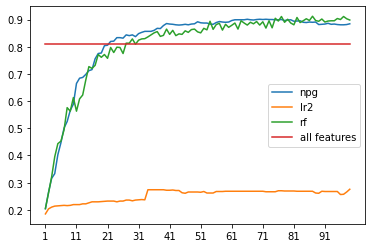

In [229]:
# extratree reward

num = 100
plt.plot(range(1, num), dats[1:num, 0], label='npg')
plt.plot(range(1, num), dats[1:num, 1], label='lr2')
plt.plot(range(1, num), dats[1:num, 2], label='rf')
plt.plot(range(1, num), dats[1:num, 3], label='all features')
plt.xticks(range(1, num, 10))
plt.legend()

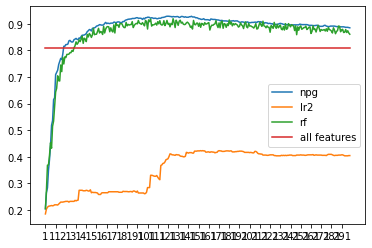

In [50]:
num = 300
plt.plot(range(1, num), dats[1:num, 0], label='npg')
plt.plot(range(1, num), dats[1:num, 1], label='lr2')
plt.plot(range(1, num), dats[1:num, 2], label='rf')
plt.plot(range(1, num), dats[1:num, 3], label='all features')
plt.xticks(range(1, num, 10))
plt.legend()

In [25]:
tmp = np.zeros((5, 300, 4))

In [51]:
tmp[4, :, :] = dats
tmp[4, :, :]

array([[0.        , 0.        , 0.        , 0.80925926],
       [0.20462963, 0.18518519, 0.20462963, 0.80925926],
       [0.26481481, 0.2037037 , 0.275     , 0.80925926],
       ...,
       [0.88703704, 0.4037037 , 0.87407407, 0.80925926],
       [0.88611111, 0.40462963, 0.86574074, 0.80925926],
       [0.88518519, 0.40462963, 0.86111111, 0.80925926]])

## run different seeds

In [378]:
def run(seed):
    start = time.time()
    print(f'random seed: {seed} is running')
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    X_shuffle, Y_shuffle = shuffle(X, Y, random_state=seed)
    x_train, x_test, y_train, y_test = train_test_split(X_shuffle, Y_shuffle, test_size=0.01, random_state=seed) # 0.3 for metrics, 0.01 for metrics_cv
    
    
    x_tt, x_val, y_tt, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=seed)  

    r_list = []
    dictionary = dict()
    theta = np.zeros(n) + 0.5
    p_list = []
    w_norm = []
    
    
    for step in range(200):
        # print('step: ', step)
        
        p_list.append(theta)
        actions = np.zeros((batch_size, n))
        p = torch.from_numpy(theta)
        for i in range(batch_size):
            action = torch.bernoulli(p)
            if action.sum() == 0:
                idx = np.random.randint(0, n, int(n/3))
                action[idx] = 1
            actions[i, :] = action.numpy()


        rewards = compute_reward(x_tt, y_tt, x_val, y_val, actions, hiddens=(128, ), num_iter=1000, lr=1e-2, batch_size=batch_size, dictionary=dictionary)
        r_list.append(rewards.mean())
        
        
        #         print(f'average reward: {rewards.mean()}')
    #     rewards = torch.tensor(rewards, dtype=torch.float32)

        # r_baseline = 0.95 * r_baseline + 0.05 * rewards.mean()

        # sampled natural policy gradient
        log_pi_grad = actions / theta - (1 - actions)/(1 - theta)


        reg = Ridge(alpha=0.1)
        reg.fit(log_pi_grad, rewards)
        w = reg.coef_

        w_norm.append(np.linalg.norm(w))

        theta = theta + 1 * w    
        theta = np.clip(theta, 0.02, 0.98)


    #     if step > 6:
    #         if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
    #             & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
    #             print(f'converge at step {step}')
    #             break

        if np.linalg.norm(theta - p_list[-1]) < 1e-3:
            print(f'converge at step {step}')
            break
            
            
    
#     tmp = sorted(dictionary.items(), key=lambda x: x[1])
#     s = set(range(n))
#     for item in tmp[:5]:
#         s = s & set(item[0])
    # print(s)
    
    
    
#     npg = np.argsort(theta)[::-1][:20]
# #     print('npg: ', npg)

#     regr = LogisticRegression(penalty='l2', fit_intercept=False, max_iter=1e6)
#     regr.fit(x_train, y_train)
#     lr2 = np.argsort(regr.coef_[0])[::-1][:20]
# #     print('logistic_l2: ', lr2)

#     regr = RandomForestClassifier(max_depth=5, random_state=0)
#     regr.fit(x_train, y_train)
#     rf = np.argsort(regr.feature_importances_)[::-1][:20]
# #     print('random_forest: ', rf)
    
    
# #     svc = SVC(gamma='auto')
# #     svc.fit(x_train, y_train)
    
    
#     # dat = np.zeros((2, 6))
#     # dat[0, 5] = 57; dat[1, 5] = svc.score(x_test, y_test)
#     # dat[0, 0] = len(acp1); dat[0, 1] = len(acp2); dat[0, 2] = len(acp3); dat[0, 3] = len(lr2); dat[0, 4] = len(rf)
#     # dat[1, 0] = metrics(acp1, x_train, x_test, y_train, y_test)
#     # dat[1, 1] = metrics(acp2, x_train, x_test, y_train, y_test)
#     # dat[1, 2] = metrics(acp3, x_train, x_test, y_train, y_test)
#     # dat[1, 3] = metrics(lr2, x_train, x_test, y_train, y_test)
#     # dat[1, 4] = metrics(rf, x_train, x_test, y_train, y_test) 

#     dat = np.zeros((2, 4))
#     dat[0, 3] = 57; dat[1, 3] = metrics_cv(range(n), X, Y).mean()
#     dat[0, 0] = len(npg); dat[0, 1] = len(lr2); dat[0, 2] = len(rf)
#     dat[1, 0] = metrics_cv(npg, X, Y).mean()
#     dat[1, 1] = metrics_cv(lr2, X, Y).mean()
#     dat[1, 2] = metrics_cv(rf, X, Y).mean()  

    num_selected = 300
    dat = np.zeros((num_selected, 4))

    for num in range(1, num_selected):

        npg = np.argsort(theta)[::-1][:num]
#         print('npg: ', np.sort(npg))

        regr = LogisticRegression(penalty='l2', fit_intercept=False, max_iter=1e6)
        regr.fit(x_train, y_train)
        lr2 = np.argsort(regr.coef_[0])[::-1][:num]
#         print('logistic_l2: ',  np.sort(lr2))

        regr = RandomForestClassifier(random_state=num)
        regr.fit(x_train, y_train)
        rf = np.argsort(regr.feature_importances_)[::-1][:num]
#         print('random_forest: ',  np.sort(rf))

        dat[num, 0] = metrics_cv(npg, X, Y).mean() 
        dat[num, 1] = metrics_cv(lr2, X, Y).mean()
        dat[num, 2] = metrics_cv(rf, X, Y).mean()
        dat[num, 3] = metrics_cv(range(n), X, Y).mean()
    
    end = time.time()
    print(f'rd: {seed} take {datetime.timedelta(seconds = end - start)}')
    
    return dat

In [379]:
if __name__ == '__main__':   # 不加这个multiprocess会报错...
    dats = []
    for sd in tqdm(range(5)):
        dats.append(run(sd))

    # print("CPU的核数为：{}".format(mp.cpu_count()))
#     start = time.time()
#     pool = mp.Pool(10)
#     dats = pool.map(run, range(10))
#     pool.close() 
#     end = time.time()
#     print(datetime.timedelta(seconds = end - start))


  0%|                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]

random seed: 0 is running



 20%|█████████████████████████████████▍                                                                                                                                     | 1/5 [55:22<3:41:29, 3322.46s/it]

rd: 0 take 0:55:22.258447
random seed: 1 is running



 40%|██████████████████████████████████████████████████████████████████                                                                                                   | 2/5 [1:50:11<2:45:09, 3303.02s/it]

rd: 1 take 0:54:49.113587
random seed: 2 is running



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 3/5 [2:45:21<1:50:11, 3306.00s/it]

rd: 2 take 0:55:09.252702
random seed: 3 is running



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 4/5 [3:40:19<55:02, 3302.81s/it]

rd: 3 take 0:54:57.587535
random seed: 4 is running


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [4:35:08<00:00, 3301.67s/it]

rd: 4 take 0:54:48.759306


In [380]:
dats = np.array([dat for dat in dats])
dats.shape

(5, 300, 4)

In [52]:
means = tmp.mean(axis=0)
print(means)
stds = tmp.std(axis=0)
print(stds)

[[0.         0.         0.         0.80925926]
 [0.20462963 0.18518519 0.20462963 0.80925926]
 [0.2662963  0.2037037  0.27074074 0.80925926]
 ...
 [0.87407407 0.40425926 0.87833333 0.80925926]
 [0.875      0.40407407 0.87703704 0.80925926]
 [0.87462963 0.40388889 0.87148148 0.80925926]]
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.00296296 0.         0.00730485 0.        ]
 ...
 [0.00979908 0.00252559 0.00323942 0.        ]
 [0.0095868  0.00199451 0.01234506 0.        ]
 [0.0092333  0.00179544 0.00843355 0.        ]]


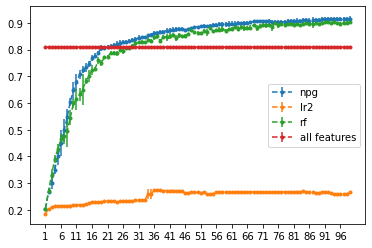

In [56]:
num = 100
plt.errorbar(range(1, num), means[1:num, 0], yerr=stds[1:num, 0], linestyle='--', fmt='.', label='npg')
plt.errorbar(range(1, num), means[1:num, 1], yerr=stds[1:num, 1], linestyle='--', fmt='.', label='lr2')
plt.errorbar(range(1, num), means[1:num, 2], yerr=stds[1:num, 2], linestyle='--', fmt='.', label='rf')
plt.errorbar(range(1, num), means[1:num, 3], yerr=stds[1:num, 3], linestyle='--', fmt='.', label='all features')
plt.xticks(range(1, num, 5))
plt.legend()

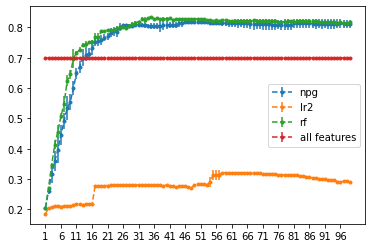

In [386]:
num = 100
plt.errorbar(range(1, num), means[1:num, 0], yerr=stds[1:num, 0], linestyle='--', fmt='.', label='npg')
plt.errorbar(range(1, num), means[1:num, 1], yerr=stds[1:num, 1], linestyle='--', fmt='.', label='lr2')
plt.errorbar(range(1, num), means[1:num, 2], yerr=stds[1:num, 2], linestyle='--', fmt='.', label='rf')
plt.errorbar(range(1, num), means[1:num, 3], yerr=stds[1:num, 3], linestyle='--', fmt='.', label='all features')
plt.xticks(range(1, num, 5))
plt.legend()

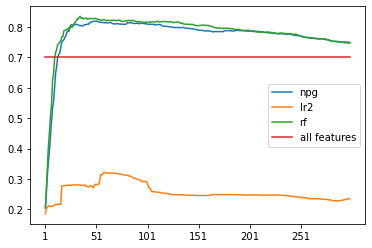

In [382]:
num = 300
plt.plot(range(1, num), means[1:num, 0], label='npg')
plt.plot(range(1, num), means[1:num, 1], label='lr2')
plt.plot(range(1, num), means[1:num, 2], label='rf')
plt.plot(range(1, num), means[1:num, 3], label='all features')
plt.xticks(range(1, num, 50))
plt.legend()

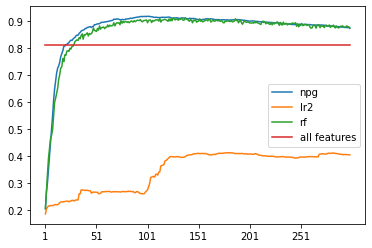

In [55]:
num = 300
plt.plot(range(1, num), means[1:num, 0], label='npg')
plt.plot(range(1, num), means[1:num, 1], label='lr2')
plt.plot(range(1, num), means[1:num, 2], label='rf')
plt.plot(range(1, num), means[1:num, 3], label='all features')
plt.xticks(range(1, num, 50))
plt.legend()

In [57]:
np.save('cnae-9_cv_npg_new.npy', tmp)

In [235]:
uji = pd.read_csv('./real_data/trainingData.csv')
uji

WAP001  WAP002  WAP003  WAP004  WAP005  WAP006  WAP007  WAP008  WAP009  \
0         100     100     100     100     100     100     100     100     100   
1         100     100     100     100     100     100     100     100     100   
2         100     100     100     100     100     100     100     -97     100   
3         100     100     100     100     100     100     100     100     100   
4         100     100     100     100     100     100     100     100     100   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
19932     100     100     100     100     100     100     100     100     100   
19933     100     100     100     100     100     100     100     100     100   
19934     100     100     100     100     100     100     100     100     100   
19935     100     100     100     100     100     100     100     100     100   
19936     100     100     100     100     100     100     100     100     100   

       WAP010  ...  WAP520  LONGITUDE      LATITUDE  FLOOR  BUILDINGID  \
0         100  ...     100 -7541.2643  4.864921e+06      2           1   
1         100  ...     100 -7536.6212  4.864934e+06      2           1   
2         100  ...     100 -7519.1524  4.864950e+06      2           1   
3         100  ...     100 -7524.5704  4.864934e+06      2           1   
4         100  ...     100 -7632.1436  4.864982e+06      0           0   
...       ...  ...     ...        ...           ...    ...         ...   
19932     100  ...     100 -7485.4686  4.864875e+06      3           1   
19933     100  ...     100 -7390.6206  4.864836e+06      1           2   
19934     100  ...     100 -7516.8415  4.864889e+06      3           1   
19935     100  ...     100 -7537.3219  4.864896e+06      3           1   
19936     100  ...     100 -7536.1658  4.864898e+06      3           1   

       SPACEID  RELATIVEPOSITION  USERID  PHONEID   TIMESTAMP  
0          106                 2       2       23  1371713733  
1          106                 2       2       23  1371713691  
2          103                 2       2       23  1371714095  
3          102                 2       2       23  1371713807  
4          122                 2      11       13  1369909710  
...        ...               ...     ...      ...         ...  
19932        1                 2      18       10  1371710683  
19933      140                 2      18       10  1371710402  
19934       13                 2      18       10  1371710921  
19935      113                 2      18       10  1371711049  
19936      112                 2      18       10  1371711025  

[19937 rows x 529 columns]

In [243]:
X = uji.iloc[:, :-9].to_numpy()
Y = uji['LONGITUDE'].to_numpy()

In [247]:
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)
scaler_y = StandardScaler()
Y = scaler_y.fit_transform(Y[:, np.newaxis])
Y = Y.ravel()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
regr = SVR()
regr.fit(x_train, y_train)
print(regr.score(x_test, y_test))
regr = RandomForestRegressor(max_depth=5)
regr.fit(x_train, y_train)
print(regr.score(x_test, y_test))
rf_sfm = SelectFromModel(regr, prefit=True)
rf = np.where(rf_sfm.get_support())[0]
# regr = RandomForestClassifier(max_depth=5)
regr = SVR()
regr.fit(x_train[:, rf], y_train)
print(regr.score(x_test[:, rf], y_test))

0.9720664236597171
0.8189158505643414
0.8881843411583522


In [397]:
qsar = pd.read_csv('./real_data/qsar_androgen_receptor.csv', sep=';', header=None)


X = qsar.iloc[:, :-1].to_numpy()
Y = qsar.iloc[:, -1].to_numpy()
Y = np.where(Y=='positive', 1, 0)

X.shape, Y.shape

((1687, 1024), (1687,))

In [405]:
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
regr = SVC(gamma='auto')
regr.fit(x_train, y_train)
print(regr.score(x_test, y_test))
regr = RandomForestClassifier(max_depth=5)
regr.fit(x_train, y_train)
print(regr.score(x_test, y_test))
rf_sfm = SelectFromModel(regr, prefit=True)
rf = np.where(rf_sfm.get_support())[0]
# regr = RandomForestClassifier(max_depth=5)
regr = SVC(gamma='auto')
regr.fit(x_train[:, rf], y_train)
print(regr.score(x_test[:, rf], y_test))

0.9092702169625246
0.9053254437869822
0.9053254437869822


In [391]:
def metrics_cv(idx, X, Y, cv=5):
#     clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf = SVC(gamma='auto')
#     clf = RandomForestRegressor()
    return cross_val_score(clf, X[:, idx], Y, cv=cv, scoring='balanced_accuracy')
#     return cross_val_score(clf, X[:, idx], Y, cv=cv)



m, n = X.shape

In [395]:
metrics_cv(range(n), X, Y, cv=5).mean()

0.540119761545936

In [396]:
metrics_cv(rf, X, Y, cv=5).mean()

0.6086273333924341

In [299]:
def compute_reward(X_train, Y_train, X_test, Y_test, actions, hiddens=(128, ), num_iter=500, lr=1e-3, batch_size='auto', dictionary=dict()):
    reward_list = []
    for i, action in enumerate(actions):
        
        idx = np.where(action == 1)[0]
        
        if tuple(idx) in dictionary:
            reward_list.append(dictionary[tuple(idx)])
        else:
            X_select = X_train[:, idx]        
#             reg_clf = MLPRegressor(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
#                                      learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
#             reg_clf = LinearRegression(fit_intercept=False)
            # reg_clf = Ridge(alpha=0.1)
            # reg_clf = RandomForestRegressor(n_estimators=50, max_depth=5)
            # reg_clf = ExtraTreesRegressor(n_estimators=50, max_depth=5)
#             reg_clf = MLPClassifier(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
#                                      learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
            # reg_clf = RandomForestClassifier(n_estimators=50, max_depth=5)
            reg_clf = ExtraTreesClassifier(n_estimators=50)
            reg_clf.fit(X_select, Y_train)
            X_select = X_test[:, idx] 
            y_pred = reg_clf.predict(X_select)
            score = balanced_accuracy_score(Y_test, y_pred)
#             score = reg_clf.score(X_select, Y_test)
            # mse = np.mean((Y_test - regressor.predict(X_select))**2)
            dictionary[tuple(idx)] = score
            reward_list.append(score)
        
    return np.array(reward_list)

In [300]:
# ============================= one run ==========================================
start = time.time()

# training steps
batch_size = 64
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.01, random_state=seed)


x_tt, x_val, y_tt, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=seed)  
r_list = []
dictionary = dict()
theta = np.zeros(n) + 0.5
p_list = []
w_norm = []


for step in range(200):
    print('step: ', step)

    p_list.append(theta)
    idx_select = np.where(theta > 0.9)[0]
    
    actions = np.zeros((batch_size, n))
    p = torch.from_numpy(theta)
    for i in range(batch_size):
        action = torch.bernoulli(p)
#         if action.sum == 0:
#             idx = np.random.randint(0, n, int(n/3))
#             action[idx] = 1
#         actions[i, :] = action.numpy()
        idx = np.random.choice(np.where(action == 1)[0], 50, replace=False)
        tmp = np.zeros(n)
        tmp[idx] = 1
        tmp[idx_select] = 1
        actions[i, :] = tmp


    rewards = compute_reward(x_tt, y_tt, x_val, y_val, actions, hiddens=(128, ), num_iter=1000, lr=1e-2, batch_size=batch_size, dictionary=dictionary)
    r_list.append(rewards.mean())
    print(f'average reward: {rewards.mean()}')
#     rewards = torch.tensor(rewards, dtype=torch.float32)


    # sampled natural policy gradient
    log_pi_grad = actions / theta - (1 - actions)/(1 - theta)


    reg = Ridge(alpha=0.1)
    reg.fit(log_pi_grad, rewards)
    w = reg.coef_

    w_norm.append(np.linalg.norm(w))

    theta = theta + 1 * w    
    theta = np.clip(theta, 0.02, 0.98)


#     if step > 6:
#         if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
#             & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
#             print(f'converge at step {step}')
#             break

    if np.linalg.norm(theta - p_list[-1]) < 1e-3:
        print(f'converge at step {step}')
        break

end = time.time()
print(f'rd: {seed} take {datetime.timedelta(seconds = end - start)}')

step:  0
average reward: 0.6022051815810594
step:  1
average reward: 0.5985770089285714
step:  2
average reward: 0.5976142405698235
step:  3
average reward: 0.5933383702849118
step:  4
average reward: 0.5928913147070625
step:  5
average reward: 0.5981556606139646
step:  6
average reward: 0.5961138142054574
step:  7
average reward: 0.599951720505618
step:  8
average reward: 0.5973048129012841
step:  9
average reward: 0.5953118729935795
step:  10
average reward: 0.600376830858748
step:  11
average reward: 0.5954291231942216
step:  12
average reward: 0.6005263718900482
step:  13
average reward: 0.5971753360754414
step:  14
average reward: 0.5992983798154092
step:  15
average reward: 0.5974248846308186
step:  16
average reward: 0.5994842872191011
step:  17
average reward: 0.598975158005618
step:  18
average reward: 0.5945948911516854
step:  19
average reward: 0.5948572933386838
step:  20
average reward: 0.5944619657905297
step:  21
average reward: 0.5968696704454254
step:  22
average rewar

average reward: 0.599932283306581
step:  182
average reward: 0.5979700667134831
step:  183
average reward: 0.5962404695024077
step:  184
average reward: 0.6043200742375602
step:  185
average reward: 0.5970931982343499
step:  186
average reward: 0.600464298254414
step:  187
average reward: 0.6001235202648475
step:  188
average reward: 0.5987008426966292
step:  189
average reward: 0.5988394111155698
step:  190
average reward: 0.5967107243178169
step:  191
average reward: 0.598781099518459
step:  192
average reward: 0.5998012389646871
step:  193
average reward: 0.5970765825642055
step:  194
average reward: 0.6012609099117175
step:  195
average reward: 0.5955752156902087
step:  196
average reward: 0.5972944672953451
step:  197
average reward: 0.5966709094101124
step:  198
average reward: 0.6036388317616372
step:  199
average reward: 0.6004395315008025
rd: 1 take 0:23:41.448274


[0.49 0.5  0.5  ... 0.5  0.51 0.49]
[]
[903  56 741 ...  85 479 576]


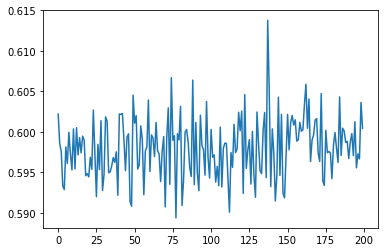

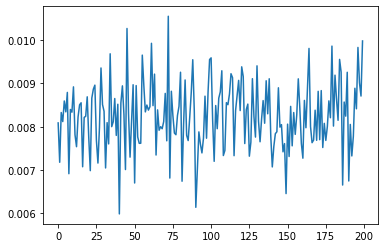

In [301]:
plt.plot(r_list)
print(np.round(theta, 2))
print(np.where(theta > 0.90)[0]+1)
print(np.argsort(theta)[::-1]+1)
plt.figure()
plt.plot(w_norm)

In [304]:
# tmp = sorted(dictionary.items(), key=lambda x: x[1])
# s = set(range(n))
# for item in tmp[:5]:
#     s = s & set(item[0])
# dic = np.array(list(s))
# print('dictionary: ', dic)


npg = np.where(theta > 0.51)[0]
print('npg: ', npg)


regr = LogisticRegression(penalty='l2', fit_intercept=False, max_iter=1e6)
regr.fit(x_train, y_train)
lr_sfm = SelectFromModel(regr, prefit=True)
lr2 = np.where(lr_sfm.get_support())[0]
print('logistic_l2: ', lr2)

regr = RandomForestClassifier(max_depth=5, random_state=0)
regr.fit(x_train, y_train)
rf_sfm = SelectFromModel(regr, prefit=True)
rf = np.where(rf_sfm.get_support())[0]
print('random_forest: ', rf)

npg:  [  14   16   44   54   55   60   62   94  123  131  157  178  184  185
  209  221  228  246  252  281  295  303  308  309  310  317  338  339
  347  350  370  371  394  413  420  441  466  480  486  489  535  538
  543  549  553  554  556  561  566  567  579  592  596  623  627  641
  648  655  667  683  687  689  696  716  721  728  732  740  756  760
  773  775  801  802  807  809  837  839  853  856  858  871  881  902
  911  917  919  923  955  959  988  995 1017 1022]
logistic_l2:  [   2    4    7    9   10   16   18   27   28   29   30   31   32   34
   35   36   37   39   40   43   44   45   49   50   54   55   60   62
   63   65   66   67   69   72   80   81   83   84   88   90   91   93
   94   96   98  102  111  112  116  119  123  124  128  129  130  131
  132  133  134  138  141  143  145  146  151  152  157  160  162  164
  165  167  170  172  173  174  175  178  179  180  183  185  189  190
  192  198  201  210  211  212  213  214  215  218  221  223  224  227
  230

In [307]:
dat = np.zeros((2, 4))
dat[0, 3] = n; dat[1, 3] = metrics_cv(range(n), X, Y).mean()
dat[0, 0] = len(npg); dat[0, 1] = len(lr2); dat[0, 2] = len(rf)
dat[1, 0] = metrics_cv(npg, X, Y).mean()
dat[1, 1] = metrics_cv(lr2, X, Y).mean()
dat[1, 2] = metrics_cv(rf, X, Y).mean()  

print(dat)

[[9.40000000e+01 4.34000000e+02 2.47000000e+02 1.02400000e+03]
 [8.93306762e-01 8.89745931e-01 8.86183344e-01 8.86782083e-01]]


## performances of different numer of selected features

In [ ]:
num_selected = 300
dats = np.zeros((num_selected, 4))

for num in range(1, num_selected):

    npg = np.argsort(theta)[::-1][:num]
    print('npg: ', np.sort(npg))

    regr = LogisticRegression(penalty='l2', fit_intercept=False, max_iter=1e6)
    regr.fit(x_train, y_train)
    lr2 = np.argsort(regr.coef_[0])[::-1][:num]
    print('logistic_l2: ',  np.sort(lr2))

    regr = RandomForestClassifier(max_depth=5, random_state=num)
    regr.fit(x_train, y_train)
    rf = np.argsort(regr.feature_importances_)[::-1][:num]
    print('random_forest: ',  np.sort(rf))
    
    dats[num, 0] = metrics_cv(npg, X, Y).mean() 
    dats[num, 1] = metrics_cv(lr2, X, Y).mean()
    dats[num, 2] = metrics_cv(rf, X, Y).mean()
    
dats[:, 3] = metrics_cv(range(n), X, Y).mean()
    
dats

npg:  [902]
logistic_l2:  [290]
random_forest:  [221]
npg:  [ 55 902]
logistic_l2:  [290 334]
random_forest:  [310 716]
npg:  [ 55 740 902]
logistic_l2:  [129 290 334]
random_forest:  [566 716 902]
npg:  [ 55 566 740 902]
logistic_l2:  [129 290 334 557]
random_forest:  [310 716 902 923]
npg:  [ 55 543 566 740 902]
logistic_l2:  [129 290 334 557 859]
random_forest:  [221 310 561 902 923]
npg:  [ 55 394 543 566 740 902]
logistic_l2:  [129 290 334 517 557 859]
random_forest:  [221 281 310 716 740 923]
npg:  [ 55 221 394 543 566 740 902]
logistic_l2:  [129 290 334 517 527 557 859]
random_forest:  [221 286 310 716 775 902 923]
npg:  [ 55 221 394 543 561 566 740 902]
logistic_l2:  [129 290 334 426 517 527 557 859]
random_forest:  [ 23 221 310 543 561 716 890 902]
npg:  [ 55 221 246 394 543 561 566 740 902]
logistic_l2:  [129 198 290 334 426 517 527 557 859]
random_forest:  [221 310 489 579 716 775 807 902 923]
npg:  [ 55 221 246 394 543 561 566 721 740 902]
logistic_l2:  [129 198 290 334 426

logistic_l2:  [  49   54   91  129  189  198  252  290  310  334  413  426  517  527
  537  557  564  600  623  646  671  716  750  778  782  857  859  888
  958  973  987 1022]
random_forest:  [ 23  55  94 221 246 281 290 308 310 334 394 413 489 517 543 556 561 566
 579 716 740 802 807 809 818 819 871 902 919 923 988 995]
npg:  [  14   54   55  184  185  221  246  281  308  339  394  413  480  543
  561  566  567  716  721  728  740  773  775  807  809  837  871  902
  911  919  923  995 1017]
logistic_l2:  [  49   54   91  129  189  198  252  290  310  334  413  426  517  527
  537  557  564  600  623  646  671  716  750  778  782  794  857  859
  888  958  973  987 1022]
random_forest:  [  23   94  185  221  281  308  310  334  394  413  440  486  489  543
  549  556  566  579  627  713  716  775  778  807  809  818  871  902
  923  959  987  988 1022]
npg:  [  14   54   55  184  185  221  246  281  308  339  394  413  480  543
  561  566  567  716  721  728  740  773  775  807  809

npg:  [  14   54   55   94  184  185  209  221  246  281  308  309  310  339
  347  394  413  480  489  543  553  561  566  567  623  641  683  689
  716  721  728  740  773  775  801  807  809  837  871  902  911  919
  923  959  995 1017]
logistic_l2:  [  16   49   54   55   63   91   94  129  189  198  252  254  290  291
  295  310  334  392  413  426  517  527  537  557  558  564  579  600
  623  646  654  671  713  716  750  751  778  782  794  857  859  888
  958  973  987 1022]
random_forest:  [  23   55   94  185  198  221  231  246  260  281  286  290  295  308
  310  334  394  413  440  486  489  517  543  549  556  557  561  566
  579  627  689  716  775  778  802  807  809  818  871  902  919  923
  959  987  988 1022]
npg:  [  14   54   55   94  184  185  209  221  246  281  308  309  310  339
  347  394  413  480  489  543  553  554  561  566  567  623  641  683
  689  716  721  728  740  773  775  801  807  809  837  871  902  911
  919  923  959  995 1017]
logistic_l2: 

random_forest:  [ 23  62  94 105 129 185 221 246 260 281 286 290 308 310 334 347 373 374
 394 413 426 440 441 486 489 517 529 530 532 543 549 556 557 561 566 579
 627 655 689 716 740 775 778 786 802 807 809 818 867 902 919 923 962 987
 988 995]
npg:  [  14   16   54   55   94  184  185  209  221  246  281  308  309  310
  317  339  347  350  394  413  420  441  480  486  489  543  553  554
  556  561  566  567  623  641  683  689  716  721  728  740  773  775
  801  807  809  837  839  856  871  902  911  919  923  959  995 1017
 1022]
logistic_l2:  [  16   49   54   55   63   91   94  129  185  189  198  214  218  246
  250  252  254  290  291  295  310  332  334  392  413  426  435  452
  517  527  537  557  558  564  567  579  593  600  623  646  654  671
  713  716  750  751  778  782  794  826  857  859  888  958  973  987
 1022]
random_forest:  [ 23  55  94 120 188 191 198 209 221 231 235 246 281 286 290 295 308 310
 334 339 394 413 440 480 486 489 517 532 543 549 554 556 557 561

random_forest:  [  23   49   55   94  184  221  231  233  235  246  260  281  290  295
  308  310  334  347  374  394  412  413  440  441  480  486  489  517
  532  543  549  556  561  566  579  627  636  689  713  716  721  728
  740  744  762  775  778  795  801  802  807  809  818  819  871  890
  902  911  919  923  935  959  988  995 1022]
npg:  [  14   16   54   55   60   94  178  184  185  209  221  246  252  281
  303  308  309  310  317  338  339  347  350  394  413  420  441  480
  486  489  543  549  553  554  556  561  566  567  592  623  627  641
  683  689  716  721  728  740  773  775  801  802  807  809  837  839
  856  871  902  911  919  923  959  995 1017 1022]
logistic_l2:  [  16   49   54   55   63   91   94  129  185  189  198  214  218  246
  250  252  254  290  291  295  303  310  332  334  341  392  408  413
  426  435  452  471  517  527  532  534  537  557  558  564  567  579
  593  600  602  623  646  654  671  713  716  750  751  760  778  782
  794  826  8

logistic_l2:  [  16   49   54   55   63   91   94  129  183  185  189  198  214  218
  235  246  250  252  254  290  291  295  303  310  332  334  341  392
  408  413  426  435  452  471  517  527  532  534  537  557  558  564
  567  579  593  600  602  623  641  646  654  671  713  716  750  751
  760  778  782  794  818  826  857  859  881  888  925  954  958  973
  985  987 1022]
random_forest:  [  17   23   26   49   55   58   63   94  140  157  191  198  209  214
  221  231  246  251  281  286  290  308  310  334  339  347  365  394
  413  420  426  432  440  480  486  489  517  532  537  543  549  554
  556  561  566  578  579  627  636  659  683  689  713  716  717  728
  770  775  778  782  802  804  807  809  818  871  902  911  919  923
  959  987 1022]
npg:  [  14   16   54   55   60   94  178  184  185  209  221  246  252  281
  295  303  308  309  310  317  338  339  347  350  370  394  413  420
  441  480  486  489  538  543  549  553  554  556  561  566  567  592
  596  

logistic_l2:  [  10   16   49   54   55   63   91   94  129  183  185  189  198  214
  218  235  246  250  252  254  290  291  295  303  310  332  334  341
  353  392  408  413  426  435  452  471  514  517  527  532  534  537
  557  558  564  567  579  593  600  602  623  641  646  654  671  713
  716  744  750  751  760  775  778  782  794  818  826  850  857  859
  881  887  888  925  954  958  973  985  987 1022]
random_forest:  [  14   17   23   26   49   55   58   94  120  129  184  185  191  209
  214  221  231  246  251  260  281  286  290  304  308  310  327  334
  339  373  374  389  394  413  420  426  432  440  441  486  489  507
  532  543  549  554  556  557  561  566  579  627  636  641  689  713
  716  717  728  740  744  775  778  786  801  802  807  809  818  871
  883  890  902  919  923  959  987  988  995 1022]
npg:  [  14   16   44   54   55   60   94  123  131  157  178  184  185  209
  221  228  246  252  281  295  303  308  309  310  317  338  339  347
  350  3

random_forest:  [  14   16   23   49   54   55   94  184  185  188  189  191  198  221
  231  246  251  260  281  286  290  295  308  310  317  334  347  365
  394  405  413  426  432  440  441  456  468  486  489  517  529  543
  546  549  554  556  557  561  564  566  579  627  629  636  648  667
  689  713  716  717  740  762  775  795  801  802  804  807  809  818
  856  871  883  890  902  911  912  923  935  949  959  962  987  988
  995 1022]
npg:  [  14   16   44   54   55   60   94  123  131  157  178  184  185  209
  221  228  246  252  281  295  303  308  309  310  317  338  339  347
  350  370  371  394  413  420  441  466  480  486  489  538  543  549
  553  554  556  561  566  567  592  596  623  627  641  648  655  683
  687  689  716  721  728  732  740  756  760  773  775  801  802  807
  809  837  839  856  858  871  881  902  911  917  919  923  955  959
  995 1017 1022]
logistic_l2:  [  10   16   49   54   55   63   91   94  129  162  183  185  189  198
  213  214  

random_forest:  [  23   26   49   54   55   85   94  102  105  124  157  167  184  185
  188  198  221  231  235  246  251  252  260  281  286  295  303  308
  310  317  327  334  337  339  365  371  373  374  389  394  413  426
  432  440  441  456  486  489  532  533  543  549  554  556  557  561
  564  566  579  627  641  645  667  689  716  740  762  775  778  786
  795  796  801  802  804  807  809  818  858  871  890  900  902  919
  923  959  973  987  988  995 1012 1022]
npg:  [  14   16   44   54   55   60   62   94  123  131  157  178  184  185
  209  221  228  246  252  281  295  303  308  309  310  317  338  339
  347  350  370  371  394  413  420  441  466  480  486  489  535  538
  543  549  553  554  556  561  566  567  592  596  623  627  641  648
  655  667  683  687  689  696  716  721  728  732  740  756  760  773
  775  801  802  807  809  837  839  853  856  858  871  881  902  911
  917  919  923  955  959  988  995 1017 1022]
logistic_l2:  [  10   16   37   49   

logistic_l2:  [  10   16   37   49   54   55   63   91   94  129  162  180  183  185
  189  198  213  214  218  235  246  250  252  254  286  290  291  295
  303  310  332  334  341  353  392  408  413  426  435  441  452  471
  493  514  517  527  532  534  537  543  557  558  564  567  579  593
  600  602  623  641  645  646  654  666  671  713  716  728  744  747
  750  751  760  775  778  782  794  818  826  850  857  859  867  881
  882  887  888  898  925  930  954  958  971  973  985  987 1006 1022]
random_forest:  [  16   23   53   54   55   62   63   87   94  105  129  167  181  184
  185  198  205  209  214  221  231  233  246  260  281  286  295  303
  308  310  317  327  334  337  373  374  394  411  413  426  432  440
  441  447  456  480  486  489  517  529  530  532  543  549  554  556
  557  561  566  579  601  627  630  636  645  655  681  683  689  713
  716  740  756  762  775  778  801  802  804  807  809  818  819  871
  881  890  899  902  911  912  919  923  949 

random_forest:  [  16   17   23   54   55   63   73   87   94  105  120  124  129  140
  141  167  184  185  188  194  198  221  231  246  251  260  281  286
  290  295  308  309  310  317  334  337  339  370  374  383  394  413
  426  432  440  441  480  486  489  517  528  530  532  543  549  554
  556  557  561  564  566  579  627  636  641  683  689  713  716  721
  728  740  744  760  762  775  778  795  796  801  802  803  807  809
  810  818  871  874  883  890  902  912  919  923  935  959  962  973
  987  988  989  995 1022]
npg:  [  14   16   44   54   55   60   62   94   95  103  123  131  157  178
  184  185  209  221  228  246  252  281  286  292  295  303  308  309
  310  317  338  339  342  347  350  370  371  394  411  413  420  441
  466  480  486  489  513  527  535  538  543  549  553  554  556  561
  566  567  579  592  596  623  627  641  648  655  667  683  687  689
  696  716  721  728  732  740  756  760  773  775  801  802  807  809
  837  839  853  856  858  8

random_forest:  [  14   16   23   26   50   55   62   94  105  120  129  147  152  181
  184  188  191  198  209  221  231  235  246  258  260  281  286  290
  295  308  310  317  327  334  339  350  370  373  374  394  405  413
  420  426  441  480  486  489  501  507  517  526  530  532  537  543
  549  556  557  561  564  566  579  627  638  659  668  681  683  689
  713  714  716  717  721  731  740  751  756  761  762  775  778  786
  801  802  804  807  809  818  858  859  871  890  902  911  912  919
  923  947  949  959  965  987  988  995 1017 1022]
npg:  [  14   16   44   54   55   60   62   94   95  103  123  131  157  178
  184  185  209  221  228  242  246  252  281  286  292  295  298  303
  308  309  310  317  338  339  342  347  350  360  370  371  394  411
  413  420  441  466  480  486  489  513  527  535  538  543  549  553
  554  556  561  566  567  579  592  596  623  627  641  648  655  667
  683  687  689  696  716  721  728  732  740  756  760  773  775  801
  8

random_forest:  [  10   16   17   23   27   46   48   55   62   78   94  105  120  124
  129  152  157  174  178  184  185  188  191  198  209  221  231  246
  252  254  260  281  286  290  295  305  308  310  317  327  334  337
  339  347  364  365  374  394  411  413  426  440  441  443  456  468
  480  486  489  517  527  532  543  549  554  556  557  561  566  579
  627  629  636  641  645  655  659  689  713  716  721  728  731  740
  741  773  775  778  786  794  796  802  807  808  809  818  819  849
  858  871  883  890  902  911  912  919  923  959  987  988  995 1012
 1017]
npg:  [  14   16   44   53   54   55   60   62   94   95  103  123  131  157
  178  184  185  209  221  228  242  246  252  255  281  286  292  295
  298  303  308  309  310  317  330  338  339  342  347  350  360  370
  371  389  394  411  413  420  441  466  468  480  486  489  513  527
  535  538  543  549  553  554  556  561  566  567  579  592  596  623
  627  641  648  655  667  683  687  689  696  7

logistic_l2:  [  10   16   37   49   50   54   55   63   91   94  129  133  162  180
  183  185  189  198  210  213  214  218  235  246  250  252  254  269
  273  281  286  290  291  295  303  310  327  332  334  341  353  375
  392  394  408  413  426  434  435  441  452  471  493  514  517  527
  532  534  537  543  557  558  564  567  579  593  595  600  602  613
  623  641  645  646  654  666  671  692  713  716  728  740  744  745
  747  750  751  760  775  778  782  794  811  818  826  840  850  857
  859  867  881  882  887  888  898  925  930  952  953  954  958  971
  973  985  987 1002 1006 1022]
random_forest:  [  14   16   23   32   55   62   94  102  105  120  129  147  157  167
  184  185  188  191  198  209  221  231  235  246  251  255  260  281
  282  286  290  295  305  308  309  310  317  328  334  347  365  370
  373  374  394  405  413  420  426  432  440  441  456  466  468  480
  486  489  497  507  517  526  529  532  543  549  554  556  557  561
  566  579  593

npg:  [   6   14   16   23   44   53   54   55   60   62   75   94   95  103
  123  131  132  157  178  184  185  209  221  228  242  246  252  255
  281  286  292  295  298  303  308  309  310  317  330  338  339  342
  347  350  360  370  371  373  389  391  394  411  413  420  441  466
  468  480  486  489  513  526  527  535  538  543  549  553  554  556
  561  564  566  567  579  592  596  623  627  641  648  655  667  683
  687  689  696  716  721  728  732  740  756  760  773  775  801  802
  807  809  819  824  837  839  853  856  858  871  881  902  905  911
  917  919  923  936  938  955  959  988  995 1017 1022]
logistic_l2:  [  10   16   37   49   50   54   55   63   91   94  119  129  133  162
  180  183  185  189  198  210  213  214  218  235  246  250  252  254
  269  273  281  286  290  291  295  303  310  327  332  334  341  353
  375  392  394  408  413  426  434  435  441  452  471  493  514  517
  527  532  534  537  543  557  558  564  567  579  593  595  600  602


logistic_l2:  [   4   10   16   37   49   50   54   55   62   63   91   94  119  129
  133  162  180  183  185  189  198  210  213  214  218  235  246  250
  252  254  269  273  281  286  290  291  295  300  303  308  310  327
  332  334  341  353  375  392  394  408  413  426  434  435  441  452
  471  493  514  517  527  532  534  537  543  557  558  564  567  579
  593  595  600  602  613  623  641  645  646  650  654  666  671  692
  713  716  717  722  728  740  744  745  747  750  751  760  775  778
  782  794  811  818  826  840  850  857  859  867  881  882  887  888
  898  923  925  930  952  953  954  958  971  973  985  987 1002 1006
 1022]
random_forest:  [   4   14   16   17   23   26   27   48   54   55   58   62   73   85
   94  102  120  124  129  140  167  178  181  185  188  198  214  218
  221  231  235  246  260  281  282  286  290  295  303  305  308  310
  317  327  334  337  339  347  365  370  371  373  374  380  389  394
  411  413  420  426  440  441  468  480

random_forest:  [  10   14   16   23   26   50   53   54   55   58   85   94  105  120
  123  124  129  157  162  184  185  188  191  198  209  217  218  220
  221  231  233  246  251  258  260  269  270  281  283  286  290  304
  305  308  309  310  317  334  337  339  340  347  364  365  373  374
  394  411  413  421  426  432  440  441  443  486  489  517  526  529
  532  543  546  549  556  557  561  563  566  567  569  578  579  590
  601  627  629  636  641  645  659  681  683  689  713  716  717  740
  756  762  773  775  778  802  804  807  809  818  819  844  871  881
  883  890  899  902  911  912  919  933  935  947  949  951  959  971
  987  988  995 1012 1022]
npg:  [   6   13   14   16   23   44   53   54   55   58   60   62   68   75
   94   95  103  123  131  132  157  178  184  185  191  194  209  221
  228  242  246  252  255  281  286  292  295  298  303  308  309  310
  317  330  338  339  342  347  350  360  370  371  373  389  391  394
  411  413  420  441  466  4

random_forest:  [  10   14   23   26   48   49   54   55   58   63   87   94  105  120
  129  131  140  144  152  157  167  178  184  185  188  191  209  214
  220  221  231  240  246  251  252  254  260  269  270  275  281  282
  286  290  295  303  304  306  308  310  317  328  334  337  347  373
  374  380  394  413  420  426  432  440  441  466  468  480  489  514
  517  527  530  532  542  543  546  549  554  556  561  566  579  584
  593  594  627  636  645  659  683  713  716  721  728  740  741  744
  756  775  778  786  795  796  801  802  803  804  807  809  818  819
  856  871  874  879  883  890  899  902  905  912  916  919  923  939
  951  959  962  973  987  988  995  999 1022]
npg:  [   6   13   14   16   23   44   53   54   55   58   60   62   68   75
   94   95  103  114  123  131  132  145  157  178  184  185  191  194
  209  221  228  242  246  252  255  269  281  286  292  295  298  303
  308  309  310  317  330  338  339  342  347  350  360  370  371  373
  389  3

random_forest:  [  14   16   23   26   44   54   55   58   62   63   73   85   94   95
  105  124  129  140  167  169  178  184  185  188  191  198  209  221
  231  233  246  251  252  258  260  269  281  282  286  290  295  308
  310  317  327  328  334  337  338  339  347  364  365  370  373  374
  394  405  413  426  432  440  441  443  466  468  473  480  486  489
  490  507  517  526  529  530  532  543  549  554  556  557  561  566
  567  569  579  601  630  636  641  659  667  683  689  713  716  717
  721  735  740  742  744  751  762  773  775  778  794  795  796  801
  802  804  807  808  809  818  819  858  859  871  877  890  891  902
  911  919  923  935  951  959  962  965  967  987  988  995 1022]
npg:  [   6   13   14   16   23   44   53   54   55   58   60   62   68   75
   76   82   94   95  103  114  123  131  132  145  157  178  184  185
  191  194  209  221  228  242  246  252  255  261  269  281  286  292
  295  298  303  307  308  309  310  317  330  338  339  34

random_forest:  [   2   13   23   26   48   54   55   58   63   87   94  129  140  144
  161  162  167  169  173  174  178  181  184  185  188  189  191  198
  201  209  218  220  221  240  242  246  251  260  261  281  286  290
  295  304  308  309  310  317  327  334  337  339  347  370  374  389
  394  411  413  420  432  435  438  440  441  447  468  486  489  505
  517  527  529  532  543  549  554  556  561  564  566  567  578  579
  602  623  627  636  641  645  655  659  667  668  681  683  684  689
  690  701  713  716  717  731  738  740  744  775  778  786  796  797
  801  802  804  807  809  818  819  857  858  871  874  890  899  900
  902  911  919  923  947  951  962  965  966  973  987  988  989  994
  995 1017 1022]
npg:  [   6   13   14   16   23   44   53   54   55   58   60   62   68   75
   76   82   94   95  103  114  123  131  132  145  157  178  184  185
  191  194  209  221  228  242  246  252  255  261  269  281  286  292
  295  298  303  307  308  309  310  3

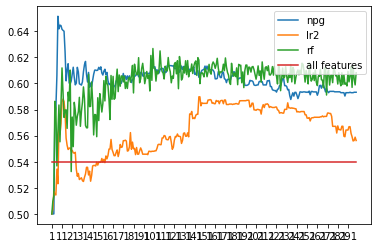

In [313]:
num = 300
plt.plot(range(1, num), dats[1:num, 0], label='npg')
plt.plot(range(1, num), dats[1:num, 1], label='lr2')
plt.plot(range(1, num), dats[1:num, 2], label='rf')
plt.plot(range(1, num), dats[1:num, 3], label='all features')
plt.xticks(range(1, num, 10))
plt.legend()

## run different seeds

In [406]:
def run(seed):
    start = time.time()
    print(f'random seed: {seed} is running')
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    X_shuffle, Y_shuffle = shuffle(X, Y, random_state=seed)
    x_train, x_test, y_train, y_test = train_test_split(X_shuffle, Y_shuffle, test_size=0.01, random_state=seed) # 0.3 for metrics, 0.01 for metrics_cv
    
    
    x_tt, x_val, y_tt, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=seed)  

    r_list = []
    dictionary = dict()
    theta = np.zeros(n) + 0.5
    p_list = []
    w_norm = []
    
    
    for step in range(200):
        # print('step: ', step)
        
        p_list.append(theta)
        idx_select = np.where(theta > 0.9)[0]

        actions = np.zeros((batch_size, n))
        p = torch.from_numpy(theta)
        for i in range(batch_size):
            action = torch.bernoulli(p)
    #         if action.sum == 0:
    #             idx = np.random.randint(0, n, int(n/3))
    #             action[idx] = 1
    #         actions[i, :] = action.numpy()
            idx = np.random.choice(np.where(action == 1)[0], 50, replace=False)
            tmp = np.zeros(n)
            tmp[idx] = 1
            tmp[idx_select] = 1
            actions[i, :] = tmp


        rewards = compute_reward(x_tt, y_tt, x_val, y_val, actions, hiddens=(128, ), num_iter=1000, lr=1e-2, batch_size=batch_size, dictionary=dictionary)
        r_list.append(rewards.mean())
        
        
        #         print(f'average reward: {rewards.mean()}')
    #     rewards = torch.tensor(rewards, dtype=torch.float32)

        # r_baseline = 0.95 * r_baseline + 0.05 * rewards.mean()

        # sampled natural policy gradient
        log_pi_grad = actions / theta - (1 - actions)/(1 - theta)


        reg = Ridge(alpha=0.1)
        reg.fit(log_pi_grad, rewards)
        w = reg.coef_

        w_norm.append(np.linalg.norm(w))

        theta = theta + 1 * w    
        theta = np.clip(theta, 0.02, 0.98)


    #     if step > 6:
    #         if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
    #             & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
    #             print(f'converge at step {step}')
    #             break

        if np.linalg.norm(theta - p_list[-1]) < 1e-3:
            print(f'converge at step {step}')
            break
            
            
    
#     tmp = sorted(dictionary.items(), key=lambda x: x[1])
#     s = set(range(n))
#     for item in tmp[:5]:
#         s = s & set(item[0])
    # print(s)
    
    
    
#     npg = np.argsort(theta)[::-1][:20]
# #     print('npg: ', npg)

#     regr = LogisticRegression(penalty='l2', fit_intercept=False, max_iter=1e6)
#     regr.fit(x_train, y_train)
#     lr2 = np.argsort(regr.coef_[0])[::-1][:20]
# #     print('logistic_l2: ', lr2)

#     regr = RandomForestClassifier(max_depth=5, random_state=0)
#     regr.fit(x_train, y_train)
#     rf = np.argsort(regr.feature_importances_)[::-1][:20]
# #     print('random_forest: ', rf)
    
    
# #     svc = SVC(gamma='auto')
# #     svc.fit(x_train, y_train)
    
    
#     # dat = np.zeros((2, 6))
#     # dat[0, 5] = 57; dat[1, 5] = svc.score(x_test, y_test)
#     # dat[0, 0] = len(acp1); dat[0, 1] = len(acp2); dat[0, 2] = len(acp3); dat[0, 3] = len(lr2); dat[0, 4] = len(rf)
#     # dat[1, 0] = metrics(acp1, x_train, x_test, y_train, y_test)
#     # dat[1, 1] = metrics(acp2, x_train, x_test, y_train, y_test)
#     # dat[1, 2] = metrics(acp3, x_train, x_test, y_train, y_test)
#     # dat[1, 3] = metrics(lr2, x_train, x_test, y_train, y_test)
#     # dat[1, 4] = metrics(rf, x_train, x_test, y_train, y_test) 

#     dat = np.zeros((2, 4))
#     dat[0, 3] = 57; dat[1, 3] = metrics_cv(range(n), X, Y).mean()
#     dat[0, 0] = len(npg); dat[0, 1] = len(lr2); dat[0, 2] = len(rf)
#     dat[1, 0] = metrics_cv(npg, X, Y).mean()
#     dat[1, 1] = metrics_cv(lr2, X, Y).mean()
#     dat[1, 2] = metrics_cv(rf, X, Y).mean()  

    num_selected = 300
    dat = np.zeros((num_selected, 4))

    for num in range(1, num_selected):

        npg = np.argsort(theta)[::-1][:num]
#         print('npg: ', np.sort(npg))

        regr = LogisticRegression(penalty='l2', fit_intercept=False, max_iter=1e6)
        regr.fit(x_train, y_train)
        lr2 = np.argsort(regr.coef_[0])[::-1][:num]
#         print('logistic_l2: ',  np.sort(lr2))

        regr = RandomForestClassifier(random_state=num)
        regr.fit(x_train, y_train)
        rf = np.argsort(regr.feature_importances_)[::-1][:num]
#         print('random_forest: ',  np.sort(rf))

        dat[num, 0] = metrics_cv(npg, X, Y).mean() 
        dat[num, 1] = metrics_cv(lr2, X, Y).mean()
        dat[num, 2] = metrics_cv(rf, X, Y).mean()
        dat[num, 3] = metrics_cv(range(n), X, Y).mean()
    
    end = time.time()
    print(f'rd: {seed} take {datetime.timedelta(seconds = end - start)}')
    
    return dat

In [407]:
if __name__ == '__main__':   # 不加这个multiprocess会报错...
    dats = []
    for sd in tqdm(range(5)):
        dats.append(run(sd))

    # print("CPU的核数为：{}".format(mp.cpu_count()))
#     start = time.time()
#     pool = mp.Pool(10)
#     dats = pool.map(run, range(10))
#     pool.close() 
#     end = time.time()
#     print(datetime.timedelta(seconds = end - start))


  0%|                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]

random seed: 0 is running



 20%|█████████████████████████████████▍                                                                                                                                     | 1/5 [55:00<3:40:03, 3300.79s/it]

rd: 0 take 0:55:00.740541
random seed: 1 is running



 40%|██████████████████████████████████████████████████████████████████                                                                                                   | 2/5 [1:45:31<2:37:06, 3142.15s/it]

rd: 1 take 0:50:31.077116
random seed: 2 is running



 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 3/5 [2:40:38<1:47:14, 3217.31s/it]

rd: 2 take 0:55:06.680236
random seed: 3 is running



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 4/5 [3:43:48<57:23, 3443.26s/it]

rd: 3 take 1:03:09.585931
random seed: 4 is running


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [4:41:16<00:00, 3375.33s/it]

rd: 4 take 0:57:28.302584


In [409]:
dats = np.array([dat for dat in dats])
dats.shape

(5, 300, 4)

In [410]:
means = dats.mean(axis=0)
print(means)
stds = dats.std(axis=0)
print(stds)

[[0.         0.         0.         0.        ]
 [0.5        0.50615478 0.5        0.54011976]
 [0.54458014 0.51974029 0.55882591 0.54011976]
 ...
 [0.58492082 0.56382929 0.60669995 0.54011976]
 [0.583408   0.56184512 0.60926575 0.54011976]
 [0.58304223 0.56068525 0.60808827 0.54011976]]
[[0.         0.         0.         0.        ]
 [0.         0.0075469  0.         0.        ]
 [0.03209902 0.00900681 0.05527856 0.        ]
 ...
 [0.00831055 0.00773651 0.00128693 0.        ]
 [0.00944124 0.0063037  0.00441678 0.        ]
 [0.00883881 0.00599721 0.00314552 0.        ]]


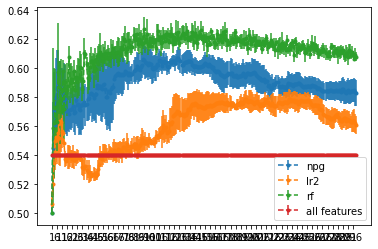

In [411]:
num = 300
plt.errorbar(range(1, num), means[1:num, 0], yerr=stds[1:num, 0], linestyle='--', fmt='.', label='npg')
plt.errorbar(range(1, num), means[1:num, 1], yerr=stds[1:num, 1], linestyle='--', fmt='.', label='lr2')
plt.errorbar(range(1, num), means[1:num, 2], yerr=stds[1:num, 2], linestyle='--', fmt='.', label='rf')
plt.errorbar(range(1, num), means[1:num, 3], yerr=stds[1:num, 3], linestyle='--', fmt='.', label='all features')
plt.xticks(range(1, num, 5))
plt.legend()

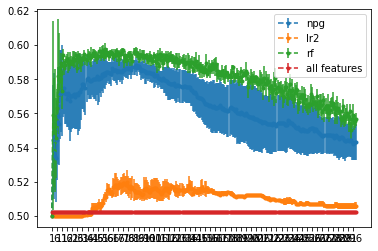

In [404]:
num = 300
plt.errorbar(range(1, num), means[1:num, 0], yerr=stds[1:num, 0], linestyle='--', fmt='.', label='npg')
plt.errorbar(range(1, num), means[1:num, 1], yerr=stds[1:num, 1], linestyle='--', fmt='.', label='lr2')
plt.errorbar(range(1, num), means[1:num, 2], yerr=stds[1:num, 2], linestyle='--', fmt='.', label='rf')
plt.errorbar(range(1, num), means[1:num, 3], yerr=stds[1:num, 3], linestyle='--', fmt='.', label='all features')
plt.xticks(range(1, num, 5))
plt.legend()

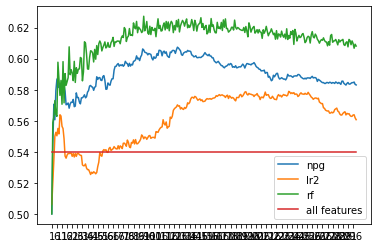

In [414]:
num = 300
plt.plot(range(1, num), means[1:num, 0], label='npg')
plt.plot(range(1, num), means[1:num, 1], label='lr2')
plt.plot(range(1, num), means[1:num, 2], label='rf')
plt.plot(range(1, num), means[1:num, 3], label='all features')
plt.xticks(range(1, num, 5))
plt.legend()

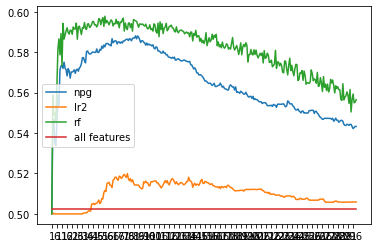

In [403]:
num = 300
plt.plot(range(1, num), means[1:num, 0], label='npg')
plt.plot(range(1, num), means[1:num, 1], label='lr2')
plt.plot(range(1, num), means[1:num, 2], label='rf')
plt.plot(range(1, num), means[1:num, 3], label='all features')
plt.xticks(range(1, num, 5))
plt.legend()

In [342]:
pad = pd.read_csv('./real_data/pd_speech_features.csv')


X = pad.iloc[:, 1:-1].to_numpy()
Y = pad.iloc[:, -1].to_numpy()

X.shape, Y.shape

((756, 753), (756,))

In [321]:
pd.value_counts(Y)

1    564
0    192
dtype: int64

In [337]:
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
regr = SVC(gamma='auto')
regr.fit(x_train, y_train)
print(regr.score(x_test, y_test))
regr = RandomForestClassifier(max_depth=5)
regr.fit(x_train, y_train)
print(regr.score(x_test, y_test))
rf_sfm = SelectFromModel(regr, prefit=True)
rf = np.where(rf_sfm.get_support())[0]
# regr = RandomForestClassifier(max_depth=5)
regr = SVC(gamma='auto')
regr.fit(x_train[:, rf], y_train)
print(regr.score(x_test[:, rf], y_test))

0.8722466960352423
0.8678414096916299
0.8766519823788547


In [338]:
metrics_cv(range(753), X, Y).mean()

0.7041545000179141

In [339]:
metrics_cv(rf, X, Y).mean()

0.72590265657336

In [340]:
def metrics_cv(idx, X, Y, cv=5):
#     clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf = SVC(gamma='auto')
#     clf = RandomForestRegressor()
    return cross_val_score(clf, X[:, idx], Y, cv=cv, scoring='balanced_accuracy')
#     return cross_val_score(clf, X[:, idx], Y, cv=cv)



m, n = X.shape

In [341]:
def compute_reward(X_train, Y_train, X_test, Y_test, actions, hiddens=(128, ), num_iter=500, lr=1e-3, batch_size='auto', dictionary=dict()):
    reward_list = []
    for i, action in enumerate(actions):
        
        idx = np.where(action == 1)[0]
        
        if tuple(idx) in dictionary:
            reward_list.append(dictionary[tuple(idx)])
        else:
            X_select = X_train[:, idx]        
#             reg_clf = MLPRegressor(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
#                                      learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
#             reg_clf = LinearRegression(fit_intercept=False)
            # reg_clf = Ridge(alpha=0.1)
            # reg_clf = RandomForestRegressor(n_estimators=50, max_depth=5)
            # reg_clf = ExtraTreesRegressor(n_estimators=50, max_depth=5)
#             reg_clf = MLPClassifier(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
#                                      learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
            # reg_clf = RandomForestClassifier(n_estimators=50, max_depth=5)
            reg_clf = ExtraTreesClassifier(n_estimators=50)
            reg_clf.fit(X_select, Y_train)
            X_select = X_test[:, idx] 
            y_pred = reg_clf.predict(X_select)
            score = balanced_accuracy_score(Y_test, y_pred)
#             score = reg_clf.score(X_select, Y_test)
            # mse = np.mean((Y_test - regressor.predict(X_select))**2)
            dictionary[tuple(idx)] = score
            reward_list.append(score)
        
    return np.array(reward_list)

In [343]:
# ============================= one run ==========================================
start = time.time()

# training steps
batch_size = 64
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.01, random_state=seed)


x_tt, x_val, y_tt, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=seed)  
r_list = []
dictionary = dict()
theta = np.zeros(n) + 0.5
p_list = []
w_norm = []


for step in range(200):
    print('step: ', step)

    p_list.append(theta)
#     idx_select = np.where(theta > 0.9)[0]
    
    actions = np.zeros((batch_size, n))
    p = torch.from_numpy(theta)
    for i in range(batch_size):
        action = torch.bernoulli(p)
        if action.sum == 0:
            idx = np.random.randint(0, n, int(n/3))
            action[idx] = 1
        actions[i, :] = action.numpy()
#         idx = np.random.choice(np.where(action == 1)[0], 50, replace=False)
#         tmp = np.zeros(n)
#         tmp[idx] = 1
#         tmp[idx_select] = 1
#         actions[i, :] = tmp


    rewards = compute_reward(x_tt, y_tt, x_val, y_val, actions, hiddens=(128, ), num_iter=1000, lr=1e-2, batch_size=batch_size, dictionary=dictionary)
    r_list.append(rewards.mean())
    print(f'average reward: {rewards.mean()}')
#     rewards = torch.tensor(rewards, dtype=torch.float32)


    # sampled natural policy gradient
    log_pi_grad = actions / theta - (1 - actions)/(1 - theta)


    reg = Ridge(alpha=0.1)
    reg.fit(log_pi_grad, rewards)
    w = reg.coef_

    w_norm.append(np.linalg.norm(w))

    theta = theta + 1 * w    
    theta = np.clip(theta, 0.02, 0.98)


#     if step > 6:
#         if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
#             & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
#             print(f'converge at step {step}')
#             break

    if np.linalg.norm(theta - p_list[-1]) < 1e-3:
        print(f'converge at step {step}')
        break

end = time.time()
print(f'rd: {seed} take {datetime.timedelta(seconds = end - start)}')

step:  0
average reward: 0.8377816594463228
step:  1
average reward: 0.8349006762468302
step:  2
average reward: 0.8382472395393068
step:  3
average reward: 0.8342543123943365
step:  4
average reward: 0.8332678439349113
step:  5
average reward: 0.8309019706255283
step:  6
average reward: 0.8325290244611159
step:  7
average reward: 0.8342477084213864
step:  8
average reward: 0.8377362571322907
step:  9
average reward: 0.8363857446639898
step:  10
average reward: 0.8387128196322907
step:  11
average reward: 0.8322937579247677
step:  12
average reward: 0.8370758598372781
step:  13
average reward: 0.8364294959847843
step:  14
average reward: 0.8362949400359255
step:  15
average reward: 0.8349031527366864
step:  16
average reward: 0.8339719925507185
step:  17
average reward: 0.8346662352071006
step:  18
average reward: 0.8411736250528318
step:  19
average reward: 0.8371831743977176
step:  20
average reward: 0.8347190669907016
step:  21
average reward: 0.8382934673499577
step:  22
average re

average reward: 0.8370890677831784
step:  182
average reward: 0.8383008968195266
step:  183
average reward: 0.8349469040574811
step:  184
average reward: 0.8355098927514792
step:  185
average reward: 0.8349947828613694
step:  186
average reward: 0.8354083566673711
step:  187
average reward: 0.840340698964497
step:  188
average reward: 0.8377833104395604
step:  189
average reward: 0.8340603206889265
step:  190
average reward: 0.8349023272400675
step:  191
average reward: 0.8355973953930684
step:  192
average reward: 0.8345283772717667
step:  193
average reward: 0.8390958500633982
step:  194
average reward: 0.8317365477071006
step:  195
average reward: 0.8402936456572274
step:  196
average reward: 0.838201011728656
step:  197
average reward: 0.8347595163250211
step:  198
average reward: 0.8352738007185122
step:  199
average reward: 0.8379673961855453
rd: 1 take 0:22:40.298154


[0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.51 0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.51 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.49 0.5  0.5  0.5  0.5  0.51
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.49 0.5  0.5  0.5  0.5  0.51
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.

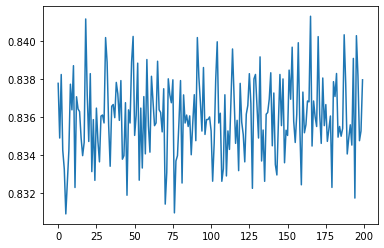

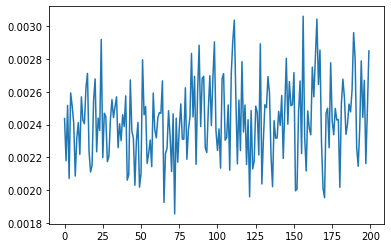

In [344]:
plt.plot(r_list)
print(np.round(theta, 2))
print(np.where(theta > 0.90)[0]+1)
print(np.argsort(theta)[::-1]+1)
plt.figure()
plt.plot(w_norm)